In [1]:
import os

interface_dir = os.environ["DATA"] + "webinterfaces/exp02/"

tasks_dir = os.path.join(interface_dir, "res", "tasks")
results_dir = os.path.join(interface_dir, "results")
protocols_dir = os.path.join(interface_dir, "protocols")
prolific_matching_dir = os.path.join(interface_dir, "prolific")

protocol_paths_d = {
    "H": os.path.join(protocols_dir, "H_0.json"),
    "H+AI": os.path.join(protocols_dir, "AI_0.json"),
    "H+AI+CF": os.path.join(protocols_dir, "XAI_CF_0.json"),
    "H+AI+SHAP": os.path.join(protocols_dir, "XAI_SHAP_0.json"),
    "H+AI+LLM": os.path.join(protocols_dir, "XAI_LLM_0.json"),
    "H+AI+GRADCAM": os.path.join(protocols_dir, "XAI_GRADCAM_0.json"),
}

COMPREHENSION_THRESHOLD = 0.8

COMPREHENSION_TASKS = ["xeasy1_find_pattern_rot"]
TRAINING_TASKS = ["med3_find_pattern_rot"]
EASY_TASKS = ["easy1_find_pattern_rot", "easy3_find_pattern_rot"]
DIFFICULT_TASKS = ["hard1_find_pattern_rot", "hard3_find_pattern_rot"]

MILD_PRESSURE_TASKS = ["easy1_find_pattern_rot", "hard1_find_pattern_rot"]
STRONG_PRESSURE_TASKS = ["easy3_find_pattern_rot", "hard3_find_pattern_rot"]

TASK_PROTOCOL_KEYS = {
    "easy1_find_pattern_rot": "mainexp_easy_mild_patrot_task",
    "easy3_find_pattern_rot": "mainexp_easy_strong_patrot_task",

    "hard1_find_pattern_rot": "mainexp_hard_mild_patrot_task",
    "hard3_find_pattern_rot": "mainexp_hard_strong_patrot_task",

    "xeasy1_find_pattern_rot": "intro_comprehension_task",
    "med3_find_pattern_rot": "intro_training_1_task"
}


In [2]:
import sys

sys.path.append("/home/jleguy/Documents/postdoc/git_repos/WebXAII/")

In [3]:
import json
import csv
import numpy as np


def load_json(path):
    with open(path) as json_file:
        return json.load(json_file)


def load_task_csv_file(path):
    y_true, y_pred = [], []
    with open(path) as csv_data:
        reader = csv.DictReader(csv_data)
        for row in reader:
            y_true.append(int(row["target"]))
            y_pred.append(int(row["pred"]))

    return np.array(y_true), np.array(y_pred)


In [4]:
import json


def data_matching(protocols_paths_d, prolific_matching_files):
    results_filenames_d = {k: [] for k in protocol_paths_d.keys()}

    for prolific_matching_file in prolific_matching_files:

        with open(prolific_matching_file) as json_data:
            d = json.load(json_data)

            for prolific_id, prot_dict in d.items():
                condition_split = prot_dict["protocol"].split("_")
                filename = prolific_id + ".json"

                if condition_split[0] == "H":
                    results_filenames_d["H"].append(filename)
                elif condition_split[0] == "AI":
                    results_filenames_d["H+AI"].append(filename)
                elif condition_split[0] == "XAI" and condition_split[1] == "SHAP":
                    results_filenames_d["H+AI+SHAP"].append(filename)
                elif condition_split[0] == "XAI" and condition_split[1] == "CF":
                    results_filenames_d["H+AI+CF"].append(filename)
                elif condition_split[0] == "XAI" and condition_split[1] == "LLM":
                    results_filenames_d["H+AI+LLM"].append(filename)
                elif condition_split[0] == "XAI" and condition_split[1] == "GRADCAM":
                    results_filenames_d["H+AI+GRADCAM"].append(filename)

    return results_filenames_d


In [5]:
from pywebxaii.resretrieval import extract_p_questionnaire_results, get_protocol_entry_from_key


def extract_quest_results(results_dir, results_filenames_d, protocol_paths_d, quest_keys):
    output_res_d = {}

    # Iterating over all groups
    for group_key, filenames_list in results_filenames_d.items():

        output_res_d[group_key] = {"raw": {}, "values": {}, "times": {}}

        # Iterating on all results files for the current group
        for filename in filenames_list:
            curr_res_path = os.path.join(results_dir, filename)
            curr_res_d = load_json(curr_res_path)
            data_issue = False
            if not curr_res_d["is_completed"]:
                data_issue = True

            # Iterating over all questionnaires keys
            for quest_key in quest_keys:

                curr_protocol_d = load_json(protocol_paths_d[group_key])
                try:
                    get_protocol_entry_from_key(curr_protocol_d, quest_key)
                    answers_raw, answers_values, quest_times = extract_p_questionnaire_results(curr_res_d,
                                                                                               quest_key,
                                                                                               protocol_d=curr_protocol_d)
                except KeyError:
                    data_issue = True

                if quest_key not in output_res_d[group_key]["raw"]:
                    output_res_d[group_key]["raw"][quest_key] = []
                    output_res_d[group_key]["values"][quest_key] = []
                    output_res_d[group_key]["times"][quest_key] = []

                if data_issue:
                    output_res_d[group_key]["raw"][quest_key].append(None)
                    output_res_d[group_key]["values"][quest_key].append(None)
                    output_res_d[group_key]["times"][quest_key].append(None)
                else:
                    output_res_d[group_key]["raw"][quest_key].append(answers_raw)
                    output_res_d[group_key]["values"][quest_key].append(answers_values)
                    output_res_d[group_key]["times"][quest_key].append(quest_times)

    return output_res_d

In [6]:
from pywebxaii.resretrieval import extract_p_task_results


def compute_scores(results_dir, results_filenames_d, protocol_paths_d, tasks_dir, tasks_names, task_protocol_keys):
    output_res_scores_d = {}
    output_res_reliance_d = {}
    output_res_overreliance_d = {}
    output_res_underreliance_d = {}
    output_res_appropriate_reliance_d = {}
    output_res_answer_times_d = {}

    # Iterating over all groups
    for group_key, filenames_list in results_filenames_d.items():

        output_res_scores_d[group_key] = []
        output_res_reliance_d[group_key] = []
        output_res_overreliance_d[group_key] = []
        output_res_underreliance_d[group_key] = []
        output_res_appropriate_reliance_d[group_key] = []
        output_res_answer_times_d[group_key] = []

        # Iterating on all results files for the current group
        for filename in filenames_list:
            curr_res_path = os.path.join(results_dir, filename)
            curr_res_d = load_json(curr_res_path)
            if not curr_res_d["is_completed"]:
                continue

            nb_questions = 0
            nb_quest_wrong_predictions = 0
            nb_quest_right_predictions = 0
            nb_correct = 0
            nb_reliance = 0
            nb_overreliance = 0
            nb_underreliance = 0
            nb_appropriate = 0
            answer_times = []
            early_break = False

            # Iterating over all tasks
            for task_idx, task_name in enumerate(tasks_names):

                task_true, ai_pred = load_task_csv_file(os.path.join(tasks_dir, task_name + "_content.csv"))

                answers_idx_vect, answers_text_vect, time_vect, _, _ = \
                    extract_p_task_results(curr_res_d,
                                           task_protocol_keys[tasks_names[task_idx]],
                                           protocol_d=load_json(protocol_paths_d[group_key]))

                nb_questions += len(answers_idx_vect)
                nb_quest_wrong_predictions += np.sum(task_true != ai_pred)
                nb_quest_right_predictions += np.sum(task_true == ai_pred)

                try:
                    nb_correct += np.sum(answers_idx_vect == np.logical_not(task_true))
                    nb_reliance += np.sum(answers_idx_vect == np.logical_not(ai_pred))
                    nb_overreliance += np.sum(np.logical_and(
                        answers_idx_vect == np.logical_not(ai_pred),
                        ai_pred != task_true
                    ))
                    nb_underreliance += np.sum(np.logical_and(
                        answers_idx_vect != np.logical_not(ai_pred),
                        ai_pred == task_true
                    ))
                    answer_times.extend((np.array(time_vect) / 1000).tolist())
                    #
                    # if np.isnan(np.sum(answers_idx_vect)):
                    #     print(f"answers {answers_idx_vect}")
                    #     print(f"true {np.logical_not(task_true)}")
                    #     print(f"ai pred {np.logical_not(ai_pred)}")
                    #     print(f"correct extracted {np.sum(answers_idx_vect == np.logical_not(task_true))}")
                    #     print(f"reliance extracted {np.sum(answers_idx_vect == np.logical_not(ai_pred))}")

                # Happens if the results file is not complete
                except ValueError:
                    print("ValueError exception")
                    output_res_scores_d[group_key].append(None)
                    output_res_reliance_d[group_key].append(None)
                    output_res_overreliance_d[group_key].append(None)
                    output_res_underreliance_d[group_key].append(None)
                    output_res_answer_times_d[group_key].append(None)
                    early_break = True
                    break

            if not early_break:
                output_res_scores_d[group_key].append(nb_correct / nb_questions)
                output_res_reliance_d[group_key].append(nb_reliance / nb_questions)
                output_res_overreliance_d[group_key].append(nb_overreliance / nb_quest_wrong_predictions)
                output_res_underreliance_d[group_key].append(nb_underreliance / nb_quest_right_predictions)
                output_res_answer_times_d[group_key].extend(answer_times)

    return output_res_scores_d, output_res_reliance_d, output_res_overreliance_d, output_res_underreliance_d, output_res_answer_times_d


In [7]:
results_filenames_d = data_matching(protocol_paths_d, [os.path.join(prolific_matching_dir, "prolific.json"),
                                                       os.path.join(prolific_matching_dir, "prolific_21-1.json"),
                                                       os.path.join(prolific_matching_dir, "prolific_21-2.json"),
                                                       os.path.join(prolific_matching_dir, "prolific_22-1.json"),
                                                       os.path.join(prolific_matching_dir, "prolific_27-1.json"),
                                                       os.path.join(prolific_matching_dir, "prolific_28-1.json"),
                                                       ])

# results_filenames_d = data_matching(protocol_paths_d, [os.path.join(prolific_matching_dir, "prolific_28-1.json")])

In [8]:
total = 0
for k, v in results_filenames_d.items():
    total += len(v)
    print(f"{k}: {len(v)}")
print(f"Total: {total}")

H: 121
H+AI: 108
H+AI+CF: 115
H+AI+SHAP: 113
H+AI+LLM: 111
H+AI+GRADCAM: 110
Total: 678


In [9]:
def filter_not_completed(results_filenames_d):
    filtered_results_filenames_d = {}

    # Iterating over all groups
    for group_key, filenames_list in results_filenames_d.items():

        filtered_results_filenames_d[group_key] = []

        # Iterating on all results files for the current group
        for filename in filenames_list:
            curr_res_path = os.path.join(results_dir, filename)
            curr_res_d = load_json(curr_res_path)
            if not curr_res_d["is_completed"]:
                continue
            filtered_results_filenames_d[group_key].append(filename)
    return filtered_results_filenames_d

In [10]:
results_filenames_d = filter_not_completed(results_filenames_d)

In [11]:
results_filenames_before_filtering = dict(results_filenames_d)

In [12]:
total = 0
for k, v in results_filenames_d.items():
    total += len(v)
    print(f"{k}: {len(v)}")
print(f"Total: {total}")

H: 99
H+AI: 99
H+AI+CF: 100
H+AI+SHAP: 97
H+AI+LLM: 99
H+AI+GRADCAM: 95
Total: 589


In [13]:
def filter_on_attention_tests(results_filenames_d):
    res = extract_quest_results(results_dir, results_filenames_d, protocol_paths_d,
                                ["attentioncheck_1", "attentioncheck_2"])
    filtered_results_filenames_d = {}

    for k, v in res.items():
        filtered_results_filenames_d[k] = []
        for i in range(len(results_filenames_d[k])):
            if v["raw"]["attentioncheck_1"][i] is None:
                passes1 = False
            else:
                passes1 = v["raw"]["attentioncheck_1"][i][0] == 2 and v["raw"]["attentioncheck_1"][i][1] == 0

            if v["raw"]["attentioncheck_2"][i] is None:
                passes2 = False
            else:
                passes2 = v["raw"]["attentioncheck_2"][i][0] == 6 and v["raw"]["attentioncheck_2"][i][1] == 0

            if passes1 and passes2:
                filtered_results_filenames_d[k].append(results_filenames_d[k][i])

    return filtered_results_filenames_d

In [14]:
results_filenames_d = filter_on_attention_tests(results_filenames_d)

In [15]:
total = 0
for k, v in results_filenames_d.items():
    total += len(v)
    print(f"{k}: {len(v)}")
print(f"Total: {total}")

H: 88
H+AI: 94
H+AI+CF: 89
H+AI+SHAP: 91
H+AI+LLM: 95
H+AI+GRADCAM: 90
Total: 547


In [16]:
print("Success rate at attention tests :")
for k, v in results_filenames_d.items():
    total += len(v)
    print(f"{k}: {len(v)/len(results_filenames_before_filtering[k])*100:.2f}%")

Success rate at attention tests :
H: 88.89%
H+AI: 94.95%
H+AI+CF: 89.00%
H+AI+SHAP: 93.81%
H+AI+LLM: 95.96%
H+AI+GRADCAM: 94.74%


In [17]:
def filter_comprehension_score(results_filenames_d):
    comprehension_score_d, _, _, _, _ = compute_scores(results_dir, results_filenames_d, protocol_paths_d, tasks_dir,
                                                       COMPREHENSION_TASKS, TASK_PROTOCOL_KEYS)
    filtered_results_filenames_d = {}

    for k, v in comprehension_score_d.items():
        filtered_results_filenames_d[k] = []
        for i in range(len(results_filenames_d[k])):
            if comprehension_score_d[k][i] >= COMPREHENSION_THRESHOLD:
                filtered_results_filenames_d[k].append(results_filenames_d[k][i])
            else:
                print(f"Rejecting sample due to comprehension score of {comprehension_score_d[k][i]}")

    return filtered_results_filenames_d


In [18]:
results_filenames_d = filter_comprehension_score(results_filenames_d)

Rejecting sample due to comprehension score of 0.4
Rejecting sample due to comprehension score of 0.6
Rejecting sample due to comprehension score of 0.4
Rejecting sample due to comprehension score of 0.6
Rejecting sample due to comprehension score of 0.6
Rejecting sample due to comprehension score of 0.4
Rejecting sample due to comprehension score of 0.4
Rejecting sample due to comprehension score of 0.4
Rejecting sample due to comprehension score of 0.6
Rejecting sample due to comprehension score of 0.4
Rejecting sample due to comprehension score of 0.6
Rejecting sample due to comprehension score of 0.6
Rejecting sample due to comprehension score of 0.6
Rejecting sample due to comprehension score of 0.6
Rejecting sample due to comprehension score of 0.4
Rejecting sample due to comprehension score of 0.6
Rejecting sample due to comprehension score of 0.6
Rejecting sample due to comprehension score of 0.6
Rejecting sample due to comprehension score of 0.6
Rejecting sample due to compreh

In [19]:
total = 0
for k, v in results_filenames_d.items():
    total += len(v)
    print(f"{k}: {len(v)}")
print(f"Total: {total}")

H: 85
H+AI: 89
H+AI+CF: 80
H+AI+SHAP: 86
H+AI+LLM: 85
H+AI+GRADCAM: 85
Total: 510


In [20]:
print(
    f"Total passing filters among complete files: {np.sum([len(v) for v in results_filenames_d.values()])}/{np.sum([len(v) for v in results_filenames_before_filtering.values()])}")

Total passing filters among complete files: 510/589


In [21]:
all_scores, all_reliance, all_overreliance, all_underreliance, all_times = compute_scores(results_dir,
                                                                                          results_filenames_d,
                                                                                          protocol_paths_d,
                                                                                          tasks_dir,
                                                                                          EASY_TASKS + DIFFICULT_TASKS,
                                                                                          TASK_PROTOCOL_KEYS)

all_scores_easy, all_reliance_easy, all_overreliance_easy, all_underreliance_easy, all_times_easy = compute_scores(
    results_dir,
    results_filenames_d,
    protocol_paths_d, tasks_dir,
    EASY_TASKS, TASK_PROTOCOL_KEYS)

all_scores_difficult, all_reliance_difficult, all_overreliance_difficult, all_underreliance_difficult, all_times_difficult = compute_scores(
    results_dir,
    results_filenames_d,
    protocol_paths_d,
    tasks_dir, DIFFICULT_TASKS,
    TASK_PROTOCOL_KEYS)

all_scores_mild, all_reliance_mild, all_overreliance_mild, all_underreliance_mild, all_times_mild = compute_scores(
    results_dir, results_filenames_d,
    protocol_paths_d, tasks_dir,
    MILD_PRESSURE_TASKS,
    TASK_PROTOCOL_KEYS)

all_scores_strong, all_reliance_strong, all_overreliance_strong, all_underreliance_strong, all_times_strong = compute_scores(
    results_dir, results_filenames_d,
    protocol_paths_d, tasks_dir,
    STRONG_PRESSURE_TASKS,
    TASK_PROTOCOL_KEYS)

comprehension_score, _, _, _, _ = compute_scores(results_dir, results_filenames_d, protocol_paths_d, tasks_dir,
                                                 COMPREHENSION_TASKS, TASK_PROTOCOL_KEYS)

# all_scores_findpatterns, all_reliance_findpatterns, all_overreliance_findpatterns = compute_scores(results_dir,
#                                                                                                    results_filenames_d,
#                                                                                                    protocol_paths_d,
#                                                                                                    tasks_dir,
#                                                                                                    FIND_PATTERNS_TASKS,
#                                                                                                    TASK_PROTOCOL_KEYS)
# all_scores_countsym, all_reliance_countsym, all_overreliance_countsym = compute_scores(results_dir, results_filenames_d,
#                                                                                        protocol_paths_d,
#                                                                                        tasks_dir, COUNT_SYMBOLS_TASKS,
#                                                                                        TASK_PROTOCOL_KEYS)

In [22]:
scores_easy_mild, reliance_easy_mild, overreliance_easy_mild, underreliance_easy_mild, answertimes_easy_mild = compute_scores(
    results_dir, results_filenames_d, protocol_paths_d, tasks_dir, ["easy1_find_pattern_rot"], TASK_PROTOCOL_KEYS)
scores_easy_strong, reliance_easy_strong, overreliance_easy_strong, underreliance_easy_strong, answertimes_easy_strong = compute_scores(
    results_dir, results_filenames_d, protocol_paths_d, tasks_dir, ["easy3_find_pattern_rot"], TASK_PROTOCOL_KEYS)
scores_hard_mild, reliance_hard_mild, overreliance_hard_mild, underreliance_hard_mild, answertimes_hard_mild = compute_scores(
    results_dir, results_filenames_d, protocol_paths_d, tasks_dir, ["hard1_find_pattern_rot"], TASK_PROTOCOL_KEYS)
scores_hard_strong, reliance_hard_strong, overreliance_hard_strong, underreliance_hard_strong, answertimes_hard_strong = compute_scores(
    results_dir, results_filenames_d, protocol_paths_d, tasks_dir, ["hard3_find_pattern_rot"], TASK_PROTOCOL_KEYS)


In [23]:
all_scores_union = {"easy;mild": scores_easy_mild,
                    "easy;strong": scores_easy_strong,
                    "hard;mild": scores_hard_mild,
                    "hard;strong": scores_hard_strong}

all_reliance_union = {"easy;mild": reliance_easy_mild,
                      "easy;strong": reliance_easy_strong,
                      "hard;mild": reliance_hard_mild,
                      "hard;strong": reliance_hard_strong}

all_overreliance_union = {"easy;mild": overreliance_easy_mild,
                          "easy;strong": overreliance_easy_strong,
                          "hard;mild": overreliance_hard_mild,
                          "hard;strong": overreliance_hard_strong}

all_underreliance_union = {"easy;mild": underreliance_easy_mild,
                           "easy;strong": underreliance_easy_strong,
                           "hard;mild": underreliance_hard_mild,
                           "hard;strong": underreliance_hard_strong}

all_answertimes_union = {"easy;mild": answertimes_easy_mild,
                         "easy;strong": answertimes_easy_strong,
                         "hard;mild": answertimes_hard_mild,
                         "hard;strong": answertimes_hard_strong}

In [24]:
data_scores_difficulty = {
    "easy tasks": all_scores_easy,
    "difficult tasks": all_scores_difficult,
}

data_scores_pressure = {
    "mild pressure tasks": all_scores_mild,
    "strong pressure tasks": all_scores_strong,
}

In [25]:
all_scores_training, all_reliance_training, all_overreliance_training, all_underreliance_training, _ = compute_scores(
    results_dir, results_filenames_d,
    protocol_paths_d, tasks_dir,
    TRAINING_TASKS, TASK_PROTOCOL_KEYS)

In [26]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns


def plot_distributions(data, group_name, title="Group Box Plot", y_lim=None, y_line=None, figsize=(14, 8)):
    rows = []
    for group, values in data.items():
        for v in values:
            rows.append({group_name: group, "value": v})
    df = pd.DataFrame(rows)

    fig, axes = plt.subplots(2, 1, figsize=figsize, sharex=True)

    sns.boxplot(
        data=df,
        x=group_name,
        y="value",
        ax=axes[0]
    )
    axes[0].set_title("Boxplot")
    axes[0].set_ylabel("Value")

    sns.violinplot(
        data=df,
        x=group_name,
        y="value",
        ax=axes[1],
        inner="box"
    )
    axes[1].set_title("Violin plot")
    axes[1].set_ylabel("Value")

    if y_line is not None:
        for ax in axes:
            ax.axhline(y_line, color="black", linestyle="--", linewidth=1)

    if y_lim is not None:
        axes[0].set_ylim(y_lim)

    fig.suptitle(title)
    plt.tight_layout()
    plt.show()


def plot_distributions_nested(
        data,
        group_name,
        dataset_name="Dataset",
        title="Group Box Plot",
        y_lim=None,
        y_line=None,
        figsize=(14, 8),
):
    rows = []

    for dataset, groups in data.items():
        for group, values in groups.items():
            for v in values:
                rows.append({
                    group_name: group,
                    "value": v,
                    dataset_name: dataset
                })

    df = pd.DataFrame(rows)

    fig, axes = plt.subplots(2, 1, figsize=figsize, sharex=True)

    sns.boxplot(
        data=df,
        x=group_name,
        y="value",
        hue=dataset_name,
        ax=axes[0]
    )
    axes[0].set_ylabel("Value")

    sns.violinplot(
        data=df,
        x=group_name,
        y="value",
        hue=dataset_name,
        ax=axes[1],
        inner="box",
    )
    axes[1].set_ylabel("Value")

    handles, labels = axes[0].get_legend_handles_labels()
    axes[0].get_legend().remove()
    axes[1].get_legend().remove()

    fig.suptitle(title, y=0.98)

    fig.legend(
        handles,
        labels,
        title=dataset_name,
        loc="upper center",
        bbox_to_anchor=(0.5, 0.93),
        ncol=len(labels),
        frameon=False
    )

    if y_line is not None:
        for ax in axes:
            ax.axhline(y_line, color="black", linestyle="--", linewidth=1)

    if y_lim is not None:
        axes[0].set_ylim(y_lim)

    plt.tight_layout(rect=[0, 0, 1, 0.88])
    plt.show()


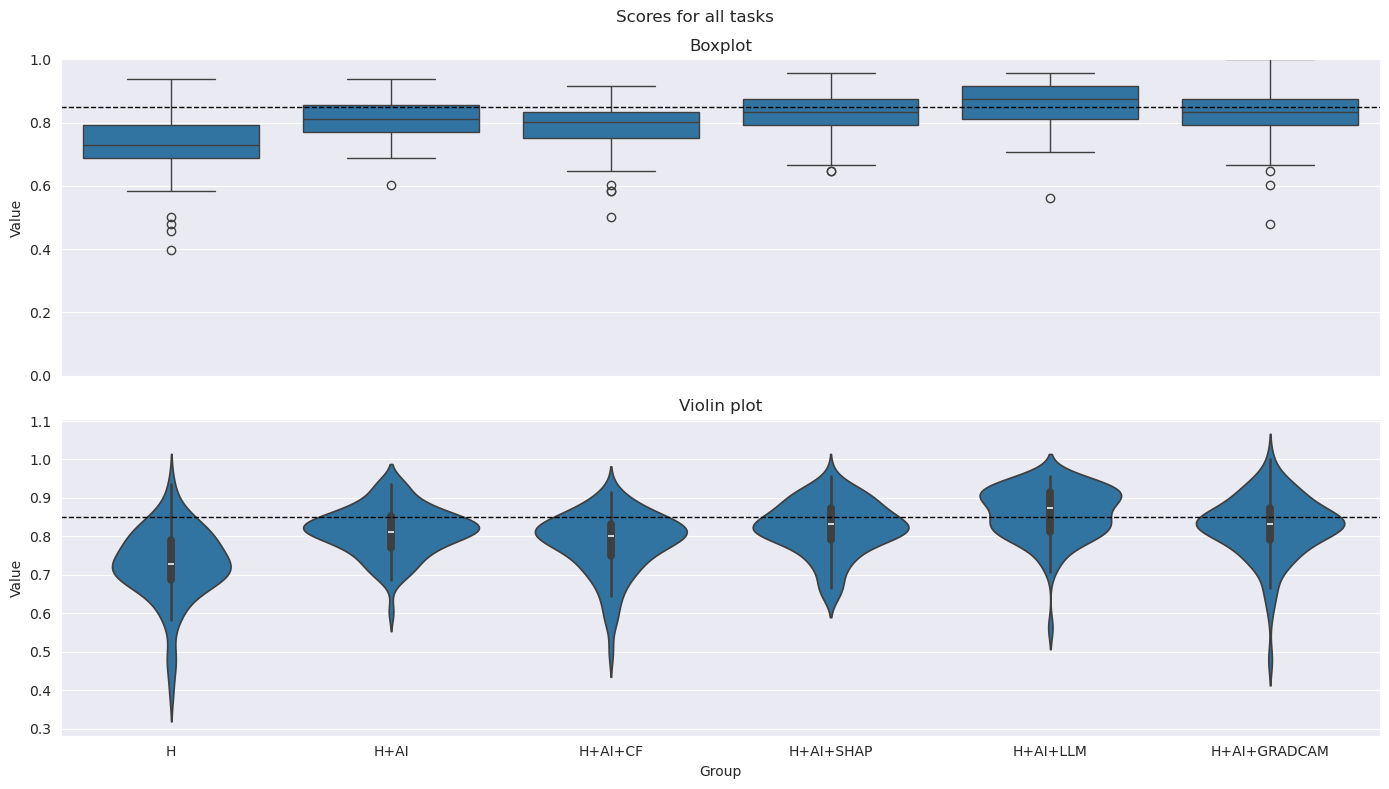

In [27]:
plot_distributions(all_scores, group_name="Group", title="Scores for all tasks", y_lim=(0, 1), y_line=0.85)


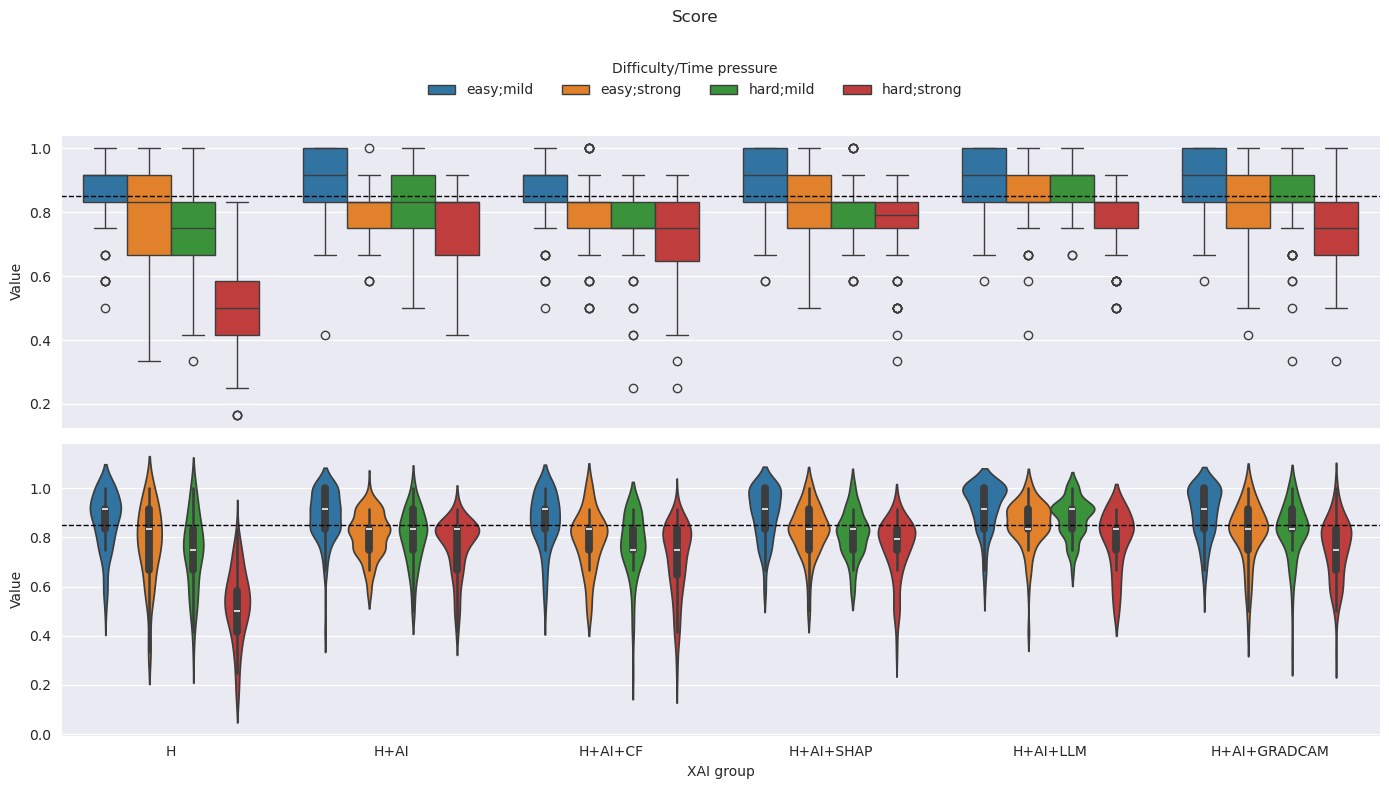

In [28]:
plot_distributions_nested(all_scores_union, "XAI group", "Difficulty/Time pressure", "Score",
                          y_line=0.85)

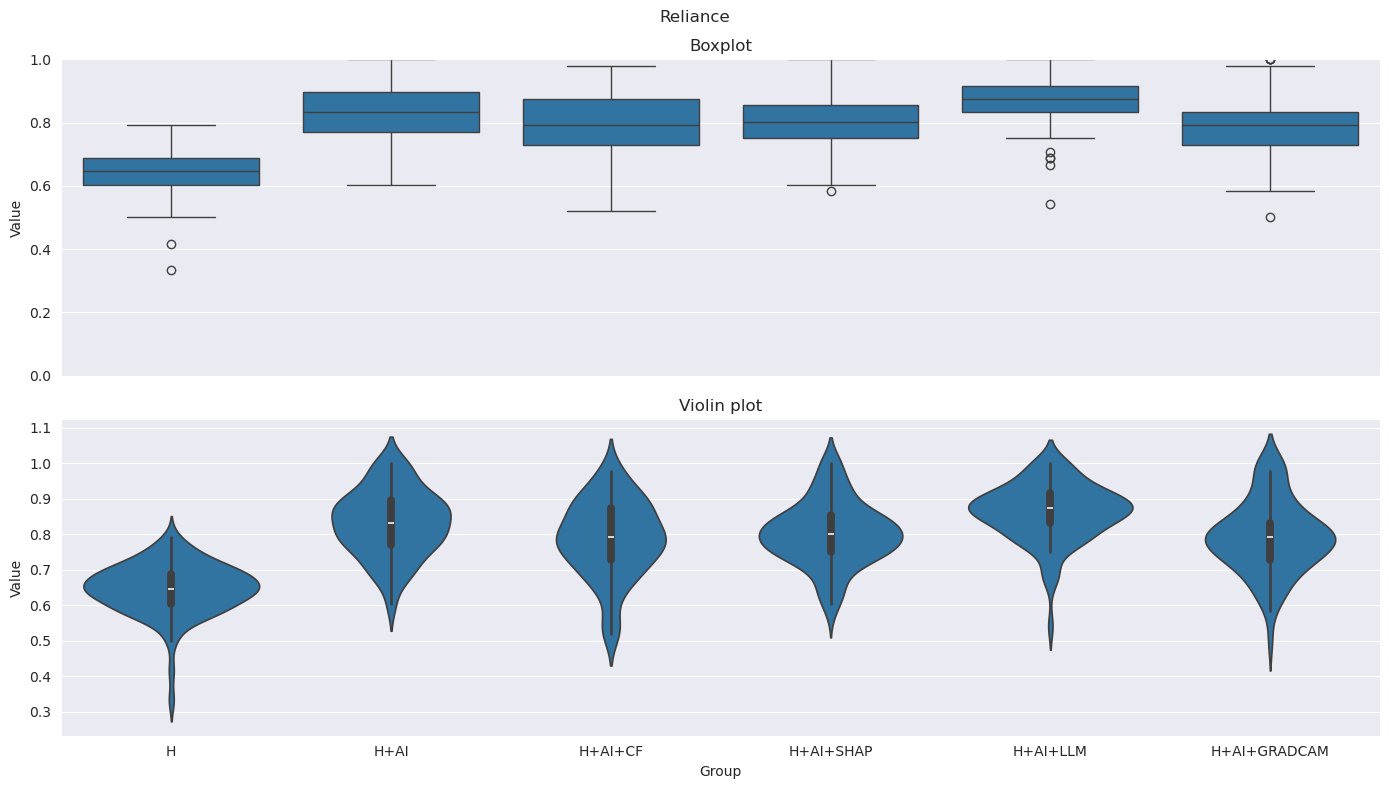

In [29]:
plot_distributions(all_reliance, "Group", title="Reliance", y_lim=(0, 1))


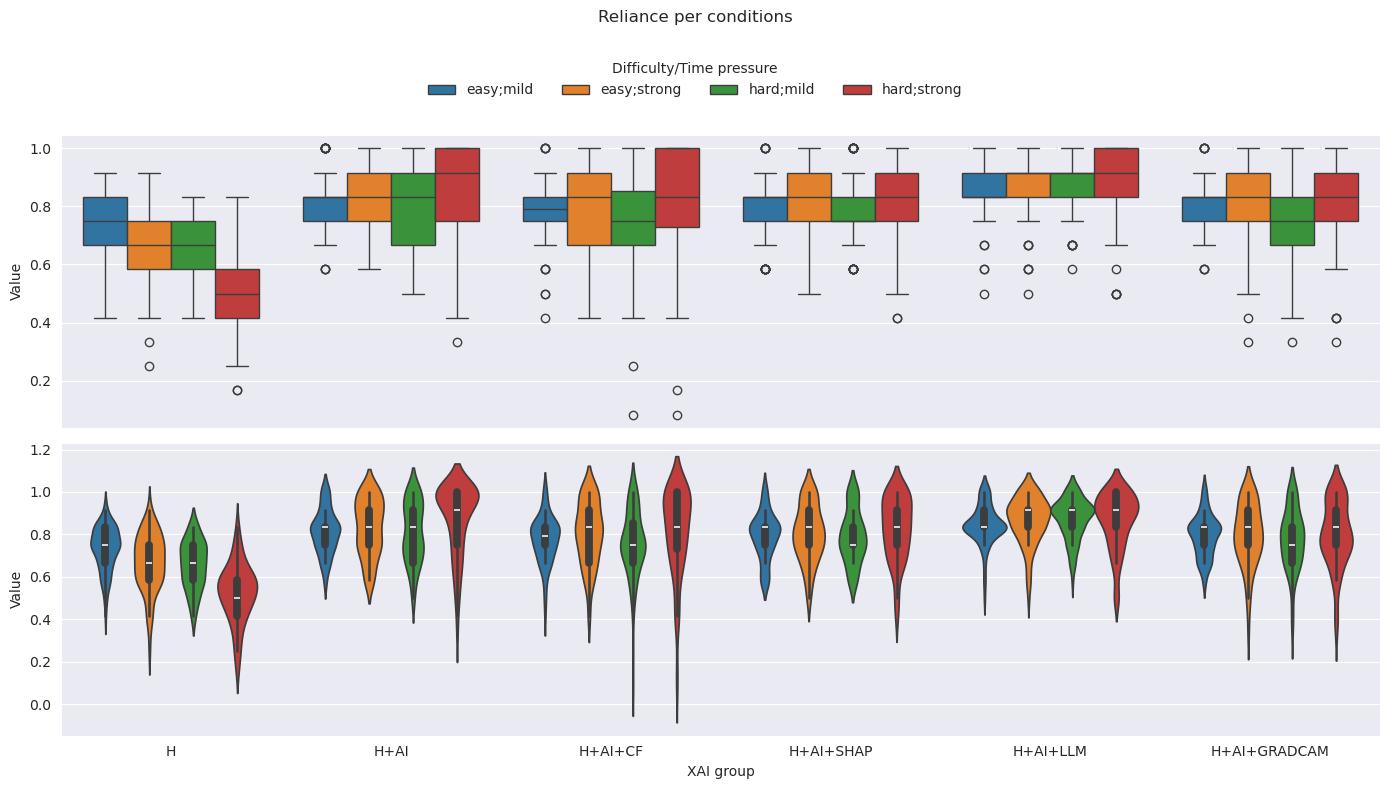

In [30]:
plot_distributions_nested(all_reliance_union, "XAI group", "Difficulty/Time pressure", "Reliance per conditions")

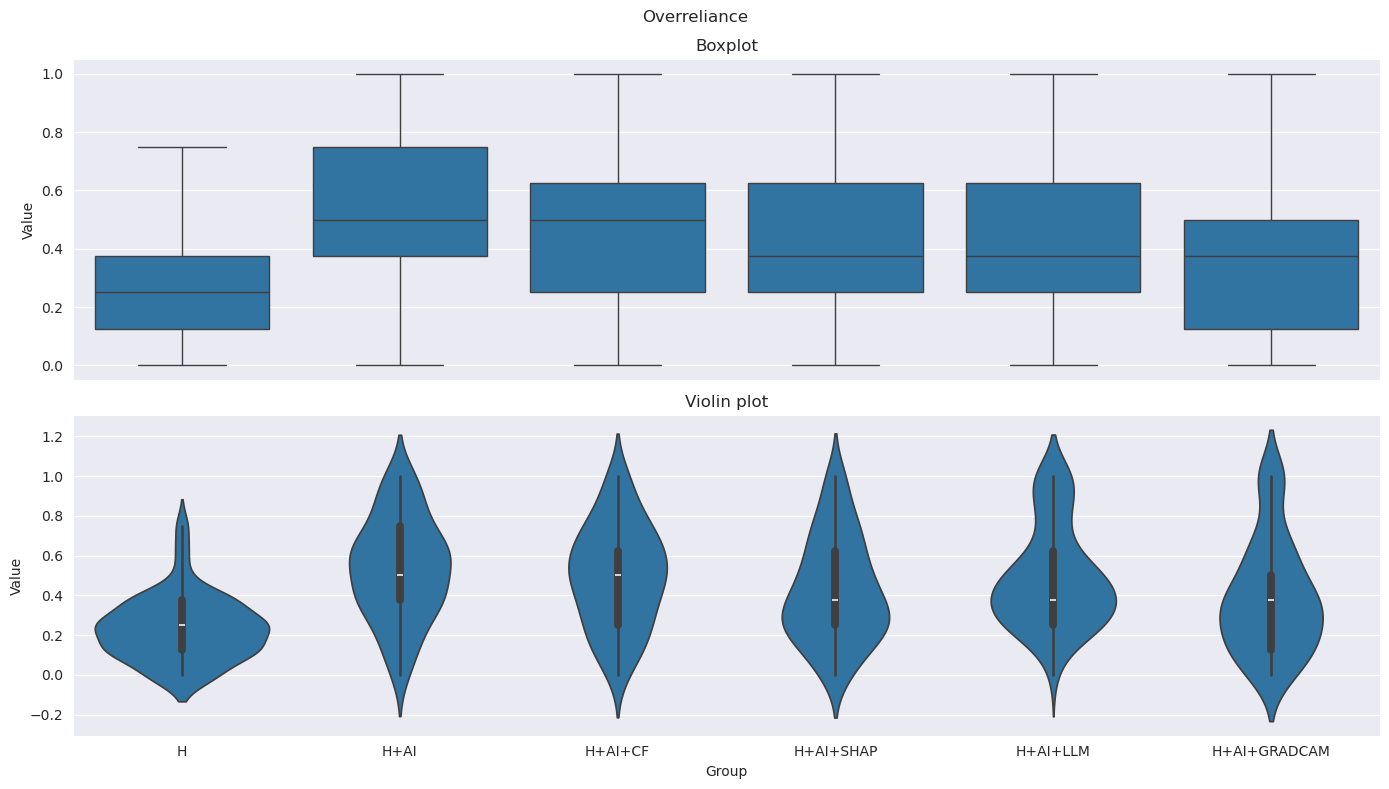

In [31]:
plot_distributions(all_overreliance, "Group", title="Overreliance")


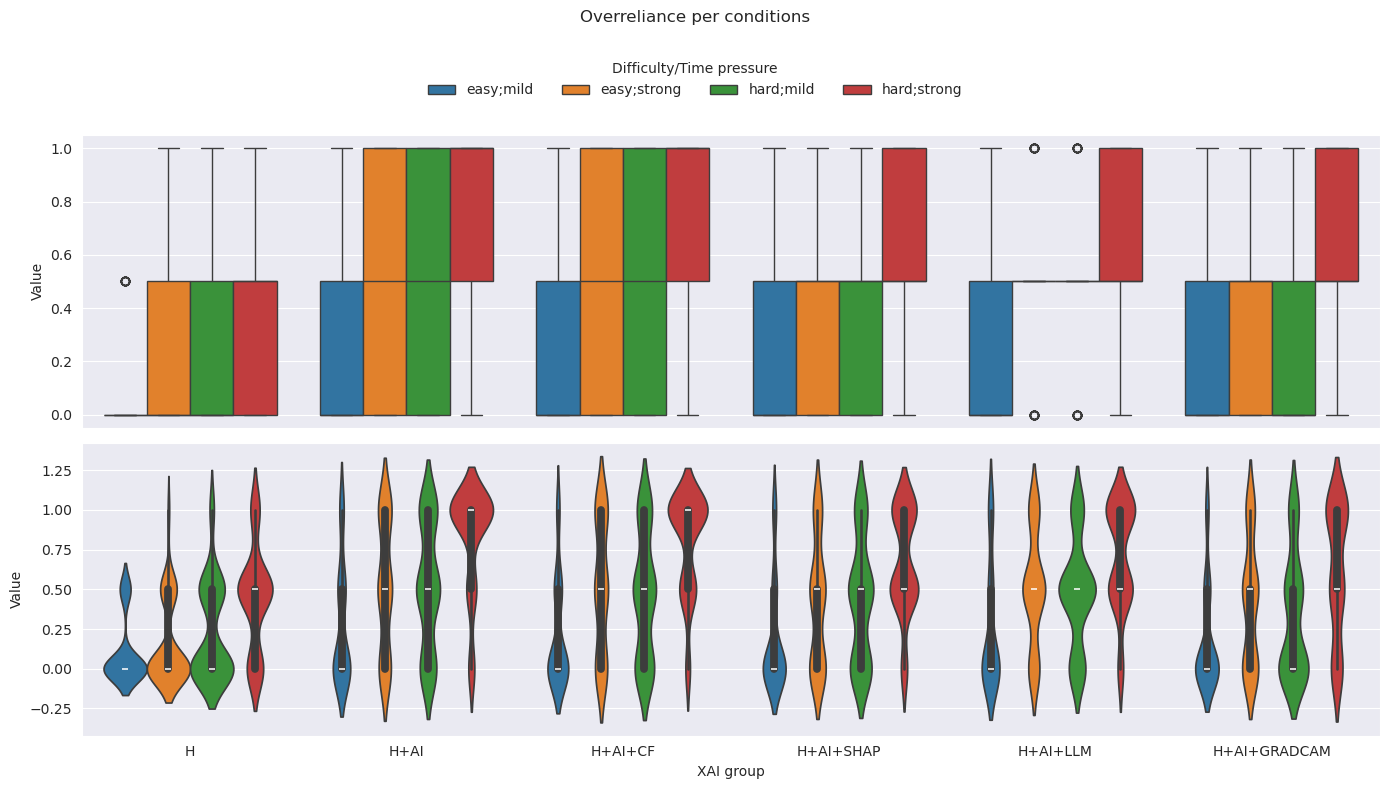

In [32]:
plot_distributions_nested(all_overreliance_union, "XAI group", "Difficulty/Time pressure",
                          "Overreliance per conditions")

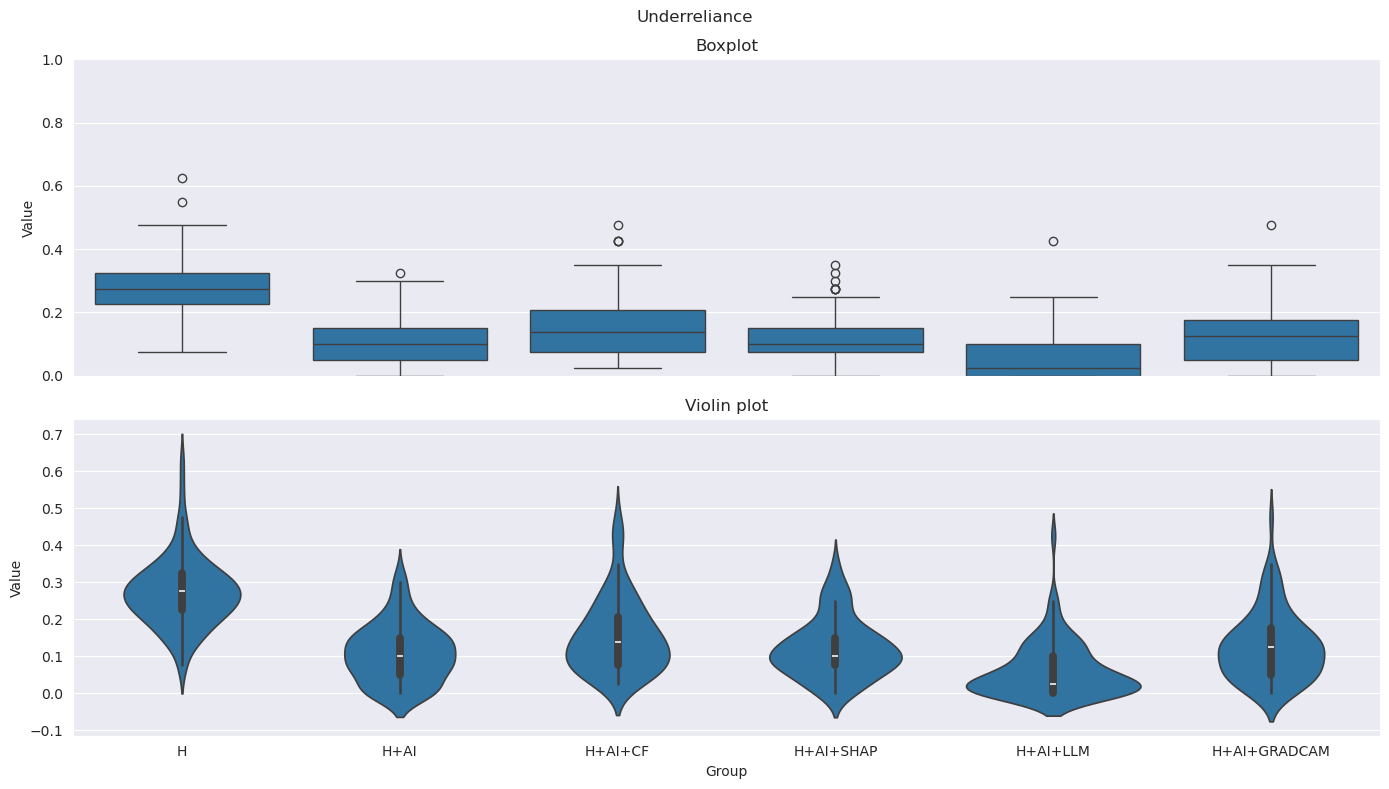

In [33]:
plot_distributions(all_underreliance, "Group", title="Underreliance", y_lim=(0, 1))


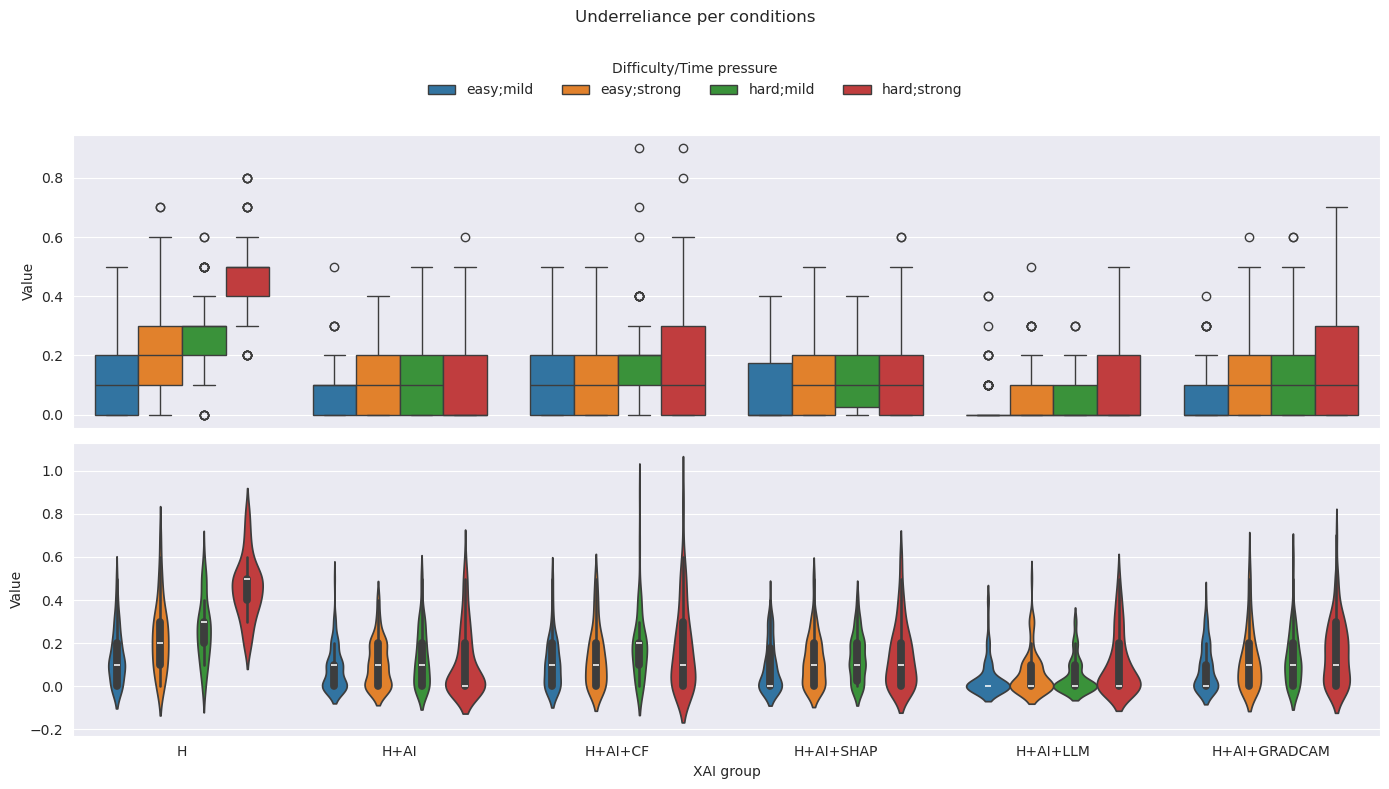

In [34]:
plot_distributions_nested(all_underreliance_union, "XAI group", "Difficulty/Time pressure",
                          "Underreliance per conditions")

In [35]:
from pywebxaii.resretrieval import extract_total_times


def extract_times(results_dir, results_filenames_d):
    output_res_d = {}

    # Iterating over all groups
    for group_key, filenames_list in results_filenames_d.items():

        output_res_d[group_key] = []

        # Iterating on all results files for the current group
        for filename in filenames_list:
            curr_res_path = os.path.join(results_dir, filename)
            curr_res_d = load_json(curr_res_path)
            if not curr_res_d["is_completed"]:
                continue
            res_dict = load_json(curr_res_path)
            total_time, _ = extract_total_times(res_dict)

            output_res_d[group_key].append(total_time / 60)

    return output_res_d


In [36]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd


def plot_histogram_with_density(data_dict, title="Histogram with Density", xlabel="Value", ylabel="Density"):
    """
    Plots a histogram with density (KDE) for each group in the data dictionary.

    Parameters:
    - data_dict: Dictionary of the form {"group1": [values], "group2": [values], ...}
    - title: Title of the plot
    - xlabel: Label for the x-axis
    - ylabel: Label for the y-axis
    """
    # Convert the dictionary to a DataFrame for easier plotting
    df = pd.DataFrame(dict([(k, pd.Series(v)) for k, v in data_dict.items()]))

    # Melt the DataFrame for seaborn
    df_melted = df.melt(var_name='groups', value_name='values')

    # Plot
    plt.figure(figsize=(10, 6))
    sns.histplot(data=df_melted, x='values', hue='groups', kde=True, element='step', stat='density', common_norm=False)

    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.show()



In [37]:
times_data = extract_times(results_dir, results_filenames_d)

In [38]:
alltimes = []
for k, v in times_data.items():
    alltimes.extend(v)
print({f"median : {np.median(alltimes)}"})

{'median : 20.869933333333336'}


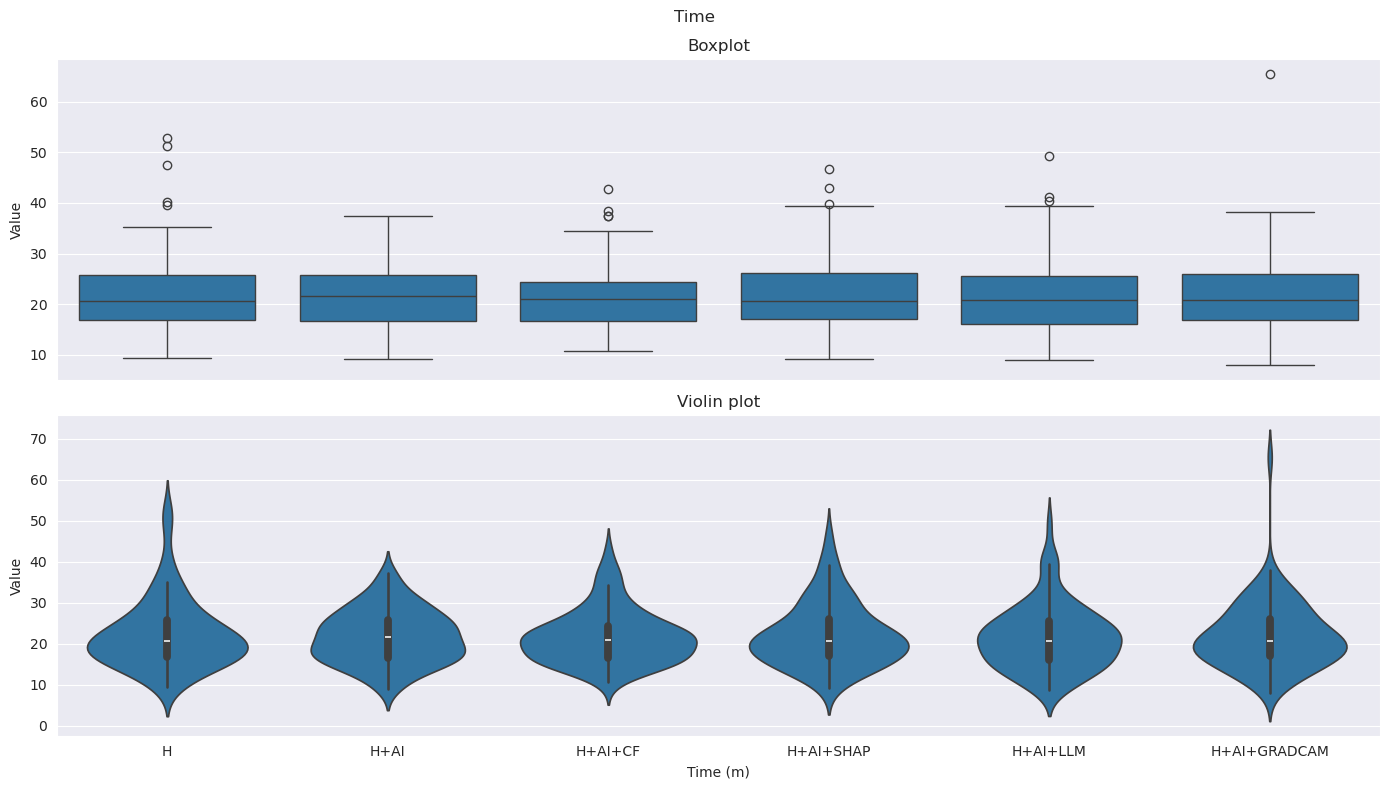

In [39]:
plot_distributions(times_data, "Time (m)", title="Time")


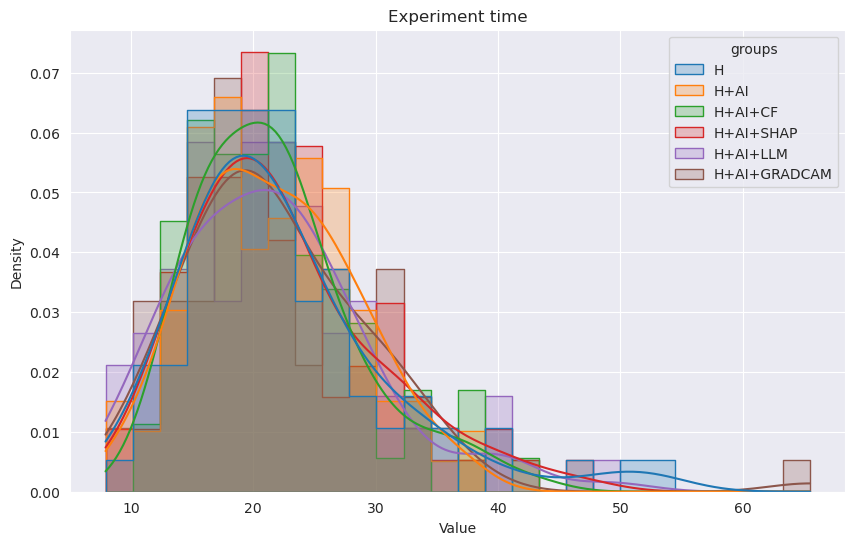

In [40]:
plot_histogram_with_density(times_data, title="Experiment time")

In [41]:
np.mean(alltimes)

np.float64(21.984508366013074)

In [42]:
3 * np.std(alltimes)

np.float64(22.690344978405385)

In [43]:
np.std(alltimes)

np.float64(7.563448326135129)

In [44]:
def process_cogload(cogload_results):

    output_d = {
        "easy;mild": {},
        "easy;strong": {},
        "hard;mild": {},
        "hard;strong": {},
    }

    for k, v in cogload_results.items():
        for session_id, results_list in v["raw"].items():

            if session_id == "mainexp_easy_mild_cogload":
                session_name = "easy;mild"
            elif session_id == "mainexp_easy_strong_cogload":
                session_name = "easy;strong"
            elif session_id == "mainexp_hard_mild_cogload":
                session_name = "hard;mild"
            elif session_id == "mainexp_hard_strong_cogload":
                session_name = "hard;strong"

            if session_id not in output_d:
                output_d[session_name][k] = []
            for result_arr in results_list:
                output_d[session_name][k].append(np.sum(result_arr))

    return output_d


In [45]:
quest_keys = ["mainexp_easy_mild_cogload", "mainexp_easy_strong_cogload", "mainexp_hard_mild_cogload",
              "mainexp_hard_strong_cogload"]

cogload_results = extract_quest_results(results_dir, results_filenames_d, protocol_paths_d, quest_keys)

In [46]:
# cogload_results

In [47]:
cogload_processed = process_cogload(cogload_results)

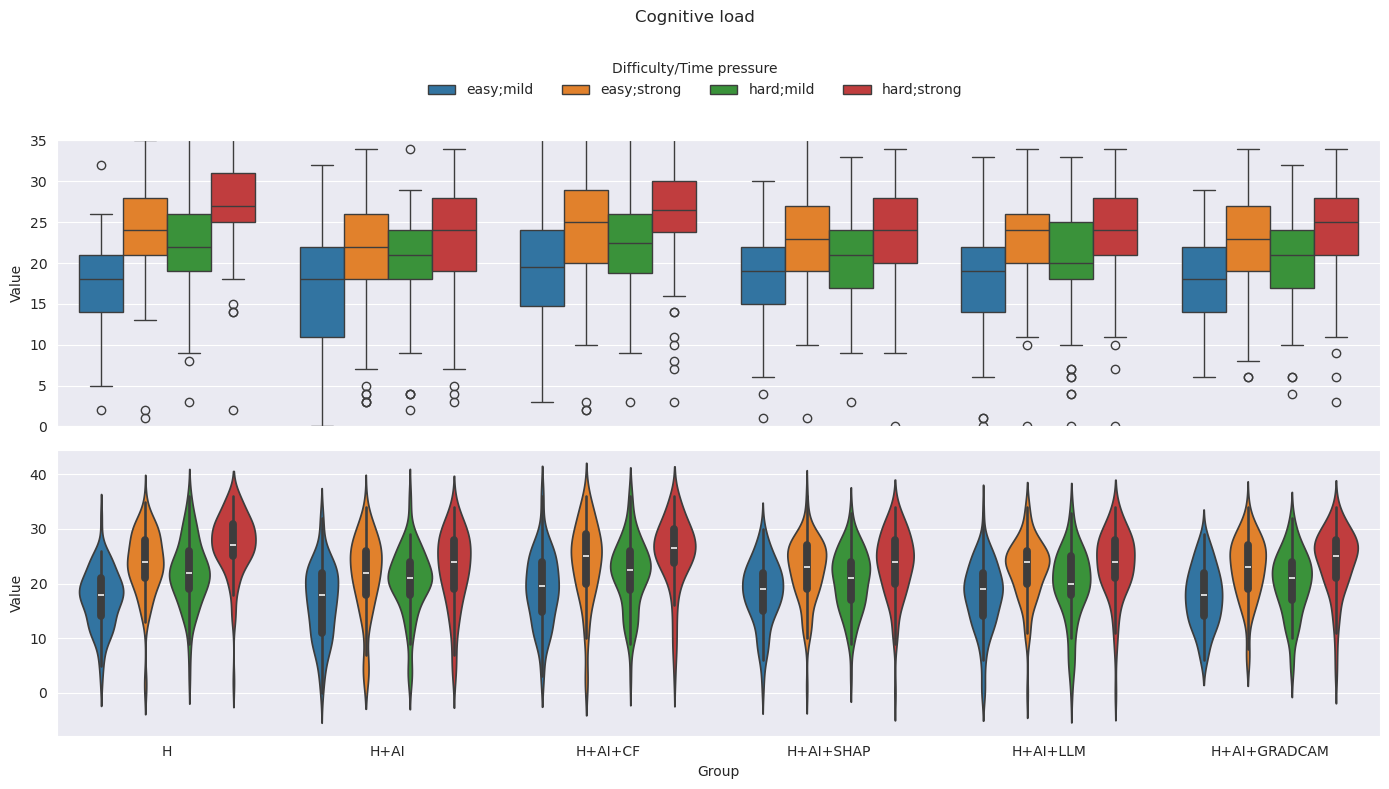

In [48]:
plot_distributions_nested(
    cogload_processed,
    "Group",
    dataset_name="Difficulty/Time pressure",
    title="Cognitive load",
    y_lim=(0, 35),
    y_line=None,
    # figsize=(7, 4),
)

In [49]:
# extract_quest_results(results_dir, results_filenames_d, protocol_paths_d, ["attentioncheck_1"])


In [50]:

# extract_quest_results(results_dir, results_filenames_d, protocol_paths_d, ["attentioncheck_2"])


In [51]:
extract_quest_results(results_dir, results_filenames_d, protocol_paths_d, ["closing_quest_strategy"])


{'H': {'raw': {'closing_quest_strategy': [None,
    None,
    None,
    None,
    None,
    None,
    None,
    None,
    None,
    None,
    None,
    None,
    None,
    None,
    None,
    None,
    None,
    None,
    None,
    None,
    None,
    None,
    None,
    None,
    None,
    None,
    None,
    None,
    None,
    None,
    None,
    None,
    None,
    None,
    None,
    None,
    None,
    None,
    None,
    None,
    None,
    None,
    None,
    None,
    None,
    None,
    None,
    None,
    None,
    None,
    None,
    None,
    None,
    None,
    None,
    None,
    None,
    None,
    None,
    None,
    None,
    None,
    None,
    None,
    None,
    None,
    None,
    None,
    None,
    None,
    None,
    None,
    None,
    None,
    None,
    None,
    None,
    None,
    None,
    None,
    None,
    None,
    None,
    None,
    None]},
  'values': {'closing_quest_strategy': [None,
    None,
    None,
    None,
    None,
    None,
    None,
    

In [52]:


def extract_trust_data(results_dir, results_filenames_d, protocol_paths_d):
    output_d = {}

    form_keys = {"mainexp_easy_mild_reliance": "easy;mild",
                 "mainexp_easy_strong_reliance": "easy;strong",
                 "mainexp_hard_mild_reliance": "hard;mild",
                 "mainexp_hard_strong_reliance": "hard;strong"
                 }

    data_input = extract_quest_results(results_dir, results_filenames_d, protocol_paths_d, form_keys)

    for form_key in form_keys.keys():

        output_d[form_keys[form_key]] = {}

        for key_group, data in data_input.items():
            output_d[form_keys[form_key]][key_group] = []


            if form_key not in data["raw"]:
                continue

            for arr in data["raw"][form_key]:
                trust = arr[0] if arr is not None else None

                if trust is not None:
                    output_d[form_keys[form_key]][key_group].append(trust)

    return output_d


In [53]:
trust_data = extract_trust_data(results_dir, results_filenames_d, protocol_paths_d)


In [54]:
def get_data_for_reliance_plots(processed_reliance_data, target_key):
    output_d = {k: {} for k in results_filenames_d.keys()}

    for group_key, group_data in processed_reliance_data.items():
        for form_key, form_data in group_data.items():
            output_d[group_key][form_key] = form_data[target_key]

    return output_d



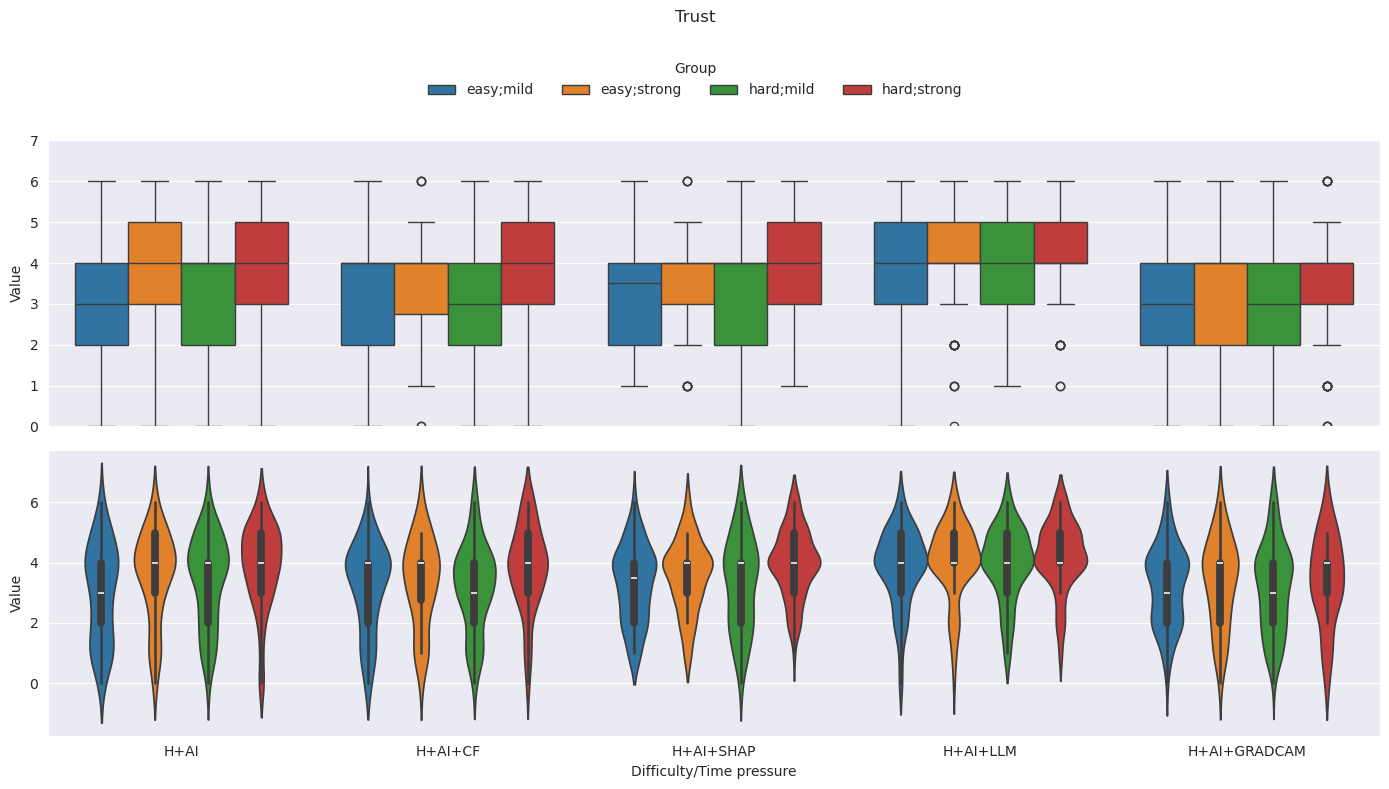

In [55]:
plot_distributions_nested(
    trust_data,
    "Difficulty/Time pressure",
    dataset_name="Group",
    title="Trust",
    y_lim=(0, 7),
    y_line=None,
    # figsize=(10, 4),
)

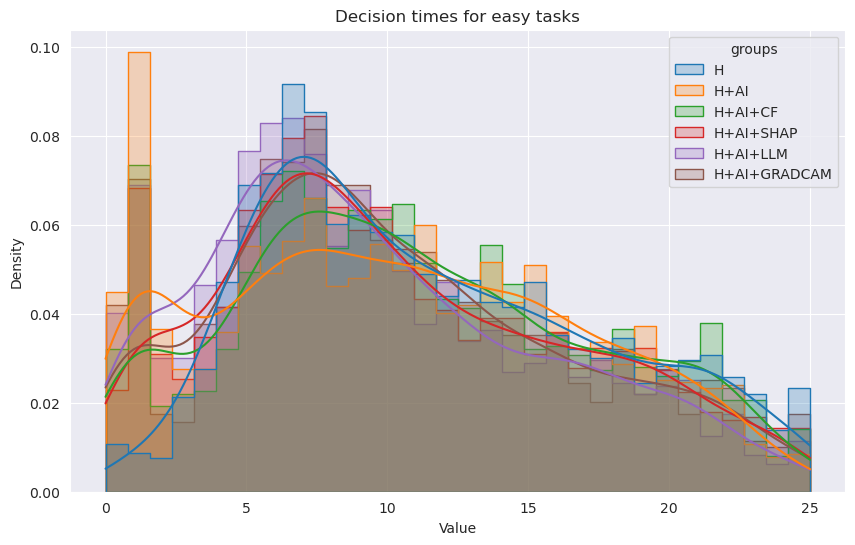

In [56]:
plot_histogram_with_density(all_times_mild, title="Decision times for easy tasks")

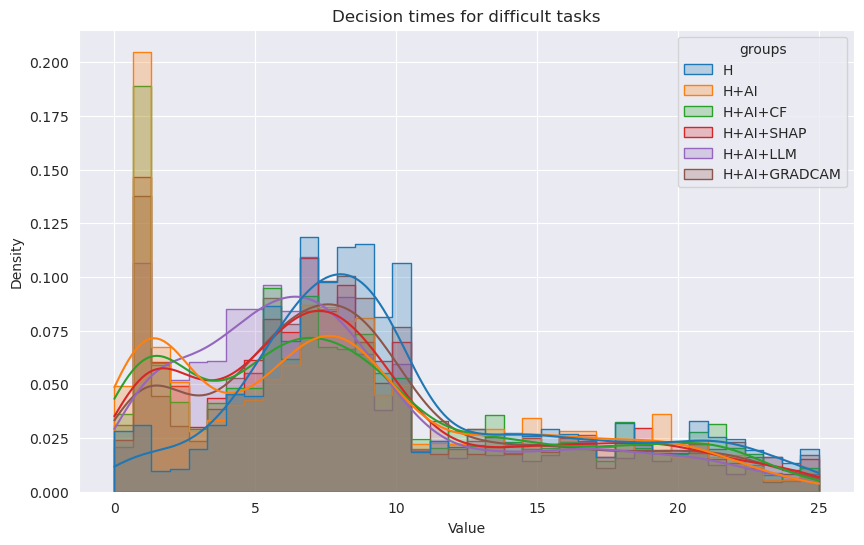

In [57]:
plot_histogram_with_density(all_times_difficult, title="Decision times for difficult tasks")

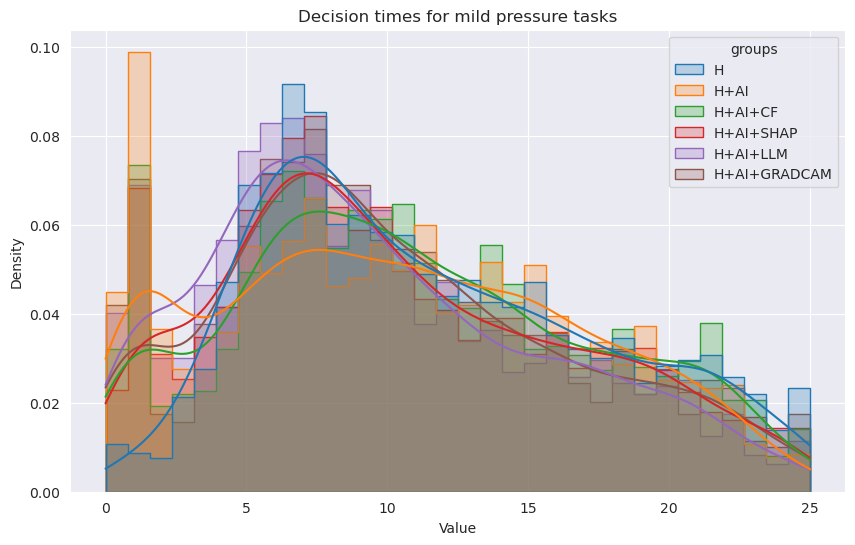

In [58]:
plot_histogram_with_density(all_times_mild, title="Decision times for mild pressure tasks")

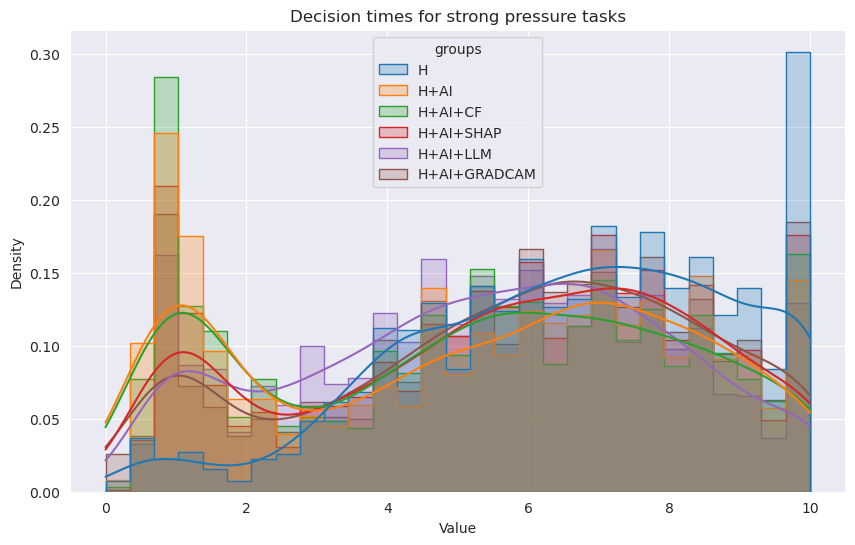

In [59]:
plot_histogram_with_density(all_times_strong, title="Decision times for strong pressure tasks")

In [60]:
def create_df():
    data_participants = []
    data_difficulty = []
    data_pressure = []
    data_reliance = []
    data_overreliance = []
    data_underreliance = []
    data_answertimes = []
    data_scores = []
    data_xai_condition = []
    data_trust = []
    data_cogload = []

    for xai_condition in ["H", "H+AI", "H+AI+SHAP", "H+AI+CF", "H+AI+GRADCAM", "H+AI+LLM"]:
        data_reliance.extend(reliance_easy_mild[xai_condition])
        data_overreliance.extend(overreliance_easy_mild[xai_condition])
        data_underreliance.extend(underreliance_easy_mild[xai_condition])
        data_answertimes.extend(answertimes_easy_mild[xai_condition])
        data_scores.extend(scores_easy_mild[xai_condition])
        curr_trust_data = trust_data["easy;mild"][xai_condition]
        data_trust.extend(
            curr_trust_data if curr_trust_data else [None for i in range(len(reliance_easy_mild[xai_condition]))])
        data_cogload.extend(cogload_processed["easy;mild"][xai_condition])
        data_difficulty.extend(["easy" for k in range(len(reliance_easy_mild[xai_condition]))])
        data_pressure.extend(["mild" for k in range(len(reliance_easy_mild[xai_condition]))])
        data_participants.extend([i + 1 for i in range(len(reliance_easy_mild[xai_condition]))])
        data_xai_condition.extend([xai_condition for k in range(len(reliance_easy_mild[xai_condition]))])

        data_reliance.extend(reliance_easy_strong[xai_condition])
        data_overreliance.extend(overreliance_easy_strong[xai_condition])
        data_underreliance.extend(underreliance_easy_strong[xai_condition])
        data_answertimes.extend(answertimes_easy_strong[xai_condition])
        data_scores.extend(scores_easy_strong[xai_condition])
        data_difficulty.extend(["easy" for k in range(len(reliance_easy_strong[xai_condition]))])
        curr_trust_data = trust_data["easy;strong"][xai_condition]
        data_trust.extend(
            curr_trust_data if curr_trust_data else [None for i in range(len(reliance_easy_strong[xai_condition]))])
        data_cogload.extend(cogload_processed["easy;strong"][xai_condition])
        data_pressure.extend(["strong" for k in range(len(reliance_easy_strong[xai_condition]))])
        data_participants.extend([i + 1 for i in range(len(reliance_easy_strong[xai_condition]))])
        data_xai_condition.extend([xai_condition for k in range(len(reliance_easy_strong[xai_condition]))])

        data_reliance.extend(reliance_hard_mild[xai_condition])
        data_overreliance.extend(overreliance_hard_mild[xai_condition])
        data_underreliance.extend(underreliance_hard_mild[xai_condition])
        data_answertimes.extend(answertimes_hard_mild[xai_condition])
        data_scores.extend(scores_hard_mild[xai_condition])
        data_difficulty.extend(["hard" for k in range(len(reliance_hard_mild[xai_condition]))])
        curr_trust_data = trust_data["hard;mild"][xai_condition]
        data_trust.extend(
            curr_trust_data if curr_trust_data else [None for i in range(len(reliance_hard_mild[xai_condition]))])
        data_cogload.extend(cogload_processed["hard;mild"][xai_condition])
        data_pressure.extend(["mild" for k in range(len(reliance_hard_mild[xai_condition]))])
        data_participants.extend([i + 1 for i in range(len(reliance_hard_mild[xai_condition]))])
        data_xai_condition.extend([xai_condition for k in range(len(reliance_hard_mild[xai_condition]))])

        data_reliance.extend(reliance_hard_strong[xai_condition])
        data_overreliance.extend(overreliance_hard_strong[xai_condition])
        data_underreliance.extend(underreliance_hard_strong[xai_condition])
        data_answertimes.extend(answertimes_hard_strong[xai_condition])
        data_scores.extend(scores_hard_strong[xai_condition])
        data_difficulty.extend(["hard" for k in range(len(reliance_hard_strong[xai_condition]))])
        curr_trust_data = trust_data["hard;strong"][xai_condition]
        data_trust.extend(
            curr_trust_data if curr_trust_data else [None for i in range(len(reliance_hard_strong[xai_condition]))])
        data_cogload.extend(cogload_processed["hard;strong"][xai_condition])
        data_pressure.extend(["strong" for k in range(len(reliance_hard_strong[xai_condition]))])
        data_participants.extend([i + 1 for i in range(len(reliance_hard_strong[xai_condition]))])
        data_xai_condition.extend([xai_condition for k in range(len(reliance_hard_strong[xai_condition]))])

    print(len(data_participants))
    print(len(data_difficulty))
    print(len(data_pressure))
    print(len(data_reliance))
    print(len(data_overreliance))
    print(len(data_underreliance))
    print(len(data_scores))
    print(len(data_trust))
    print(len(data_cogload))
    print(len(data_xai_condition))
    return pd.DataFrame({
        "participant": data_participants,
        "difficulty": data_difficulty,
        "pressure": data_pressure,
        "reliance": data_reliance,
        "overreliance": data_overreliance,
        "underreliance": data_underreliance,
        "score": data_scores,
        "trust": data_trust,
        "cogload": data_cogload,
        "xai_condition": data_xai_condition
    })


In [61]:
df = create_df()
# df["participant"] = df["participant"].astype("category")
df["pressure"] = df["pressure"].astype("category")
df["difficulty"] = df["difficulty"].astype("category")
df["xai_condition"] = df["xai_condition"].astype("category")

df["pressure"] = pd.Categorical(
    df["pressure"],
    categories=["mild", "strong"],
    ordered=True
)

df["difficulty"] = pd.Categorical(
    df["difficulty"],
    categories=["easy", "hard"],
    ordered=True
)

df["xai_condition"] = pd.Categorical(
    df["xai_condition"],
    categories=["H", "H+AI", "H+AI+CF", "H+AI+SHAP", "H+AI+LLM", "H+AI+GRADCAM"],
    ordered=False
)


2040
2040
2040
2040
2040
2040
2040
2040
2040
2040


In [62]:
df

,participant,difficulty,pressure,reliance,overreliance,underreliance,score,trust,cogload,xai_condition
0,1,easy,mild,0.666667,0.0,0.2,0.833333,NaN,11,H
1,2,easy,mild,0.666667,0.0,0.2,0.833333,NaN,24,H
2,3,easy,mild,0.750000,0.0,0.1,0.916667,NaN,12,H
3,4,easy,mild,0.750000,0.5,0.2,0.750000,NaN,24,H
4,5,easy,mild,0.750000,0.0,0.1,0.916667,NaN,20,H
...,...,...,...,...,...,...,...,...,...,...
2035,81,hard,strong,0.916667,0.5,0.0,0.916667,5.0,33,H+AI+LLM
2036,82,hard,strong,0.666667,0.0,0.2,0.833333,4.0,19,H+AI+LLM
2037,83,hard,strong,1.000000,1.0,0.0,0.833333,6.0,21,H+AI+LLM
2038,84,hard,strong,0.916667,0.5,0.0,0.916667,4.0,19,H+AI+LLM


## Test of hypotheses

### Hypotheses 1 (related to time pressure)
Each hypothesis is tested for every group with AI, against the data of the same group
with no time pressure/difficulty. Effects of pressure and
difficulty are studied independently + their interaction

* (1.a) Higher time pressure and higher difficulty increase reliance.

In [63]:
from statsmodels.stats.multitest import multipletests
import statsmodels.formula.api as smf

pvals_pressure = []
pvals_difficulty = []
pvals_both = []
labels = []
for xai_group in ["H", "H+AI", "H+AI+CF", "H+AI+SHAP", "H+AI+LLM", "H+AI+GRADCAM"]:
    df_group = df[df["xai_condition"] == xai_group]
    print(xai_group)
    model = smf.mixedlm(
        "reliance ~ pressure * difficulty",
        df_group,
        groups=df_group["participant"]
    )
    result = model.fit()

    pval_pressure = result.pvalues["pressure[T.strong]"]
    pval_difficulty = result.pvalues["difficulty[T.hard]"]
    pval_both = result.pvalues["pressure[T.strong]:difficulty[T.hard]"]
    pvals_pressure.append(pval_pressure)
    pvals_difficulty.append(pval_difficulty)
    pvals_both.append(pval_both)
    labels.append(xai_group)

    print(result.summary())


def show_holm_results(pvals):
    reject, pvals_holm, _, _ = multipletests(
        pvals,
        alpha=0.05,
        method="holm"
    )

    for g, p_raw, p_adj, sig in zip(labels, pvals, pvals_holm, reject):
        print(
            f"{g:12s}  raw p = {p_raw:.4f}  "
            f"Holm p = {p_adj:.4f}  "
            f"{'SIGNIFICANT' if sig else 'ns'}"
        )


print("Pressure")
show_holm_results(pvals_pressure)

print("Difficulty")
show_holm_results(pvals_difficulty)

print("Both")
show_holm_results(pvals_both)


H
                     Mixed Linear Model Regression Results
Model:                      MixedLM         Dependent Variable:         reliance
No. Observations:           340             Method:                     REML    
No. Groups:                 85              Scale:                      0.0130  
Min. group size:            4               Log-Likelihood:             223.3696
Max. group size:            4               Converged:                  Yes     
Mean group size:            4.0                                                 
--------------------------------------------------------------------------------
                                      Coef.  Std.Err.   z    P>|z| [0.025 0.975]
--------------------------------------------------------------------------------
Intercept                              0.733    0.013 55.102 0.000  0.707  0.759
pressure[T.strong]                    -0.065    0.017 -3.700 0.000 -0.099 -0.030
difficulty[T.hard]                    -0.076    

/home/jleguy/anaconda3/envs/Pytorch_exp/lib/python3.12/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/home/jleguy/anaconda3/envs/Pytorch_exp/lib/python3.12/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/home/jleguy/anaconda3/envs/Pytorch_exp/lib/python3.12/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/home/jleguy/anaconda3/envs/Pytorch_exp/lib/python3.12/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


                     Mixed Linear Model Regression Results
Model:                      MixedLM         Dependent Variable:         reliance
No. Observations:           344             Method:                     REML    
No. Groups:                 86              Scale:                      0.0119  
Min. group size:            4               Log-Likelihood:             219.8741
Max. group size:            4               Converged:                  Yes     
Mean group size:            4.0                                                 
--------------------------------------------------------------------------------
                                      Coef.  Std.Err.   z    P>|z| [0.025 0.975]
--------------------------------------------------------------------------------
Intercept                              0.793    0.014 56.535 0.000  0.765  0.820
pressure[T.strong]                     0.011    0.017  0.640 0.522 -0.022  0.043
difficulty[T.hard]                    -0.001    0.

/home/jleguy/anaconda3/envs/Pytorch_exp/lib/python3.12/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/home/jleguy/anaconda3/envs/Pytorch_exp/lib/python3.12/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


* (1.b) Higher time pressure and higher difficulty increase overreliance.

In [64]:
from statsmodels.stats.multitest import multipletests
import statsmodels.formula.api as smf

pvals_pressure = []
pvals_difficulty = []
pvals_both = []
labels = []
for xai_group in ["H", "H+AI", "H+AI+CF", "H+AI+SHAP", "H+AI+LLM", "H+AI+GRADCAM"]:
    df_group = df[df["xai_condition"] == xai_group]
    print(xai_group)
    model = smf.mixedlm(
        "overreliance ~ pressure * difficulty",
        df_group,
        groups=df_group["participant"]
    )
    result = model.fit()

    pval_pressure = result.pvalues["pressure[T.strong]"]
    pval_difficulty = result.pvalues["difficulty[T.hard]"]
    pval_both = result.pvalues["pressure[T.strong]:difficulty[T.hard]"]
    pvals_pressure.append(pval_pressure)
    pvals_difficulty.append(pval_difficulty)
    pvals_both.append(pval_both)
    labels.append(xai_group)

    print(result.summary())


print("Pressure")
show_holm_results(pvals_pressure)

print("Difficulty")
show_holm_results(pvals_difficulty)

print("Both")
show_holm_results(pvals_both)


H
                    Mixed Linear Model Regression Results
Model:                    MixedLM       Dependent Variable:       overreliance
No. Observations:         340           Method:                   REML        
No. Groups:               85            Scale:                    0.0661      
Min. group size:          4             Log-Likelihood:           -48.8362    
Max. group size:          4             Converged:                Yes         
Mean group size:          4.0                                                 
------------------------------------------------------------------------------
                                      Coef. Std.Err.   z   P>|z| [0.025 0.975]
------------------------------------------------------------------------------
Intercept                             0.100    0.030 3.346 0.001  0.041  0.159
pressure[T.strong]                    0.059    0.039 1.492 0.136 -0.018  0.136
difficulty[T.hard]                    0.135    0.039 3.431 0.001  0.058

/home/jleguy/anaconda3/envs/Pytorch_exp/lib/python3.12/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


                    Mixed Linear Model Regression Results
Model:                    MixedLM       Dependent Variable:       overreliance
No. Observations:         344           Method:                   REML        
No. Groups:               86            Scale:                    0.0805      
Min. group size:          4             Log-Likelihood:           -115.3722   
Max. group size:          4             Converged:                Yes         
Mean group size:          4.0                                                 
------------------------------------------------------------------------------
                                      Coef. Std.Err.   z   P>|z| [0.025 0.975]
------------------------------------------------------------------------------
Intercept                             0.198    0.039 5.099 0.000  0.122  0.274
pressure[T.strong]                    0.215    0.043 4.971 0.000  0.130  0.300
difficulty[T.hard]                    0.233    0.043 5.374 0.000  0.148  

* (1.c) Higher time pressure and higher difficulty decrease trust.


In [65]:
df_H1c = df[df["xai_condition"] != "H"]


In [66]:
from statsmodels.stats.multitest import multipletests
import statsmodels.formula.api as smf

pvals_pressure = []
pvals_difficulty = []
pvals_both = []
labels = []
for xai_group in ["H+AI", "H+AI+CF", "H+AI+SHAP", "H+AI+LLM", "H+AI+GRADCAM"]:
    df_group = df_H1c[df_H1c["xai_condition"] == xai_group]
    print(xai_group)
    model = smf.mixedlm(
        "trust ~ pressure * difficulty",
        df_group,
        groups=df_group["participant"]
    )
    result = model.fit()

    pval_pressure = result.pvalues["pressure[T.strong]"]
    pval_difficulty = result.pvalues["difficulty[T.hard]"]
    pval_both = result.pvalues["pressure[T.strong]:difficulty[T.hard]"]
    pvals_pressure.append(pval_pressure)
    pvals_difficulty.append(pval_difficulty)
    pvals_both.append(pval_both)
    labels.append(xai_group)

    print(result.summary())


def show_holm_results(pvals):
    reject, pvals_holm, _, _ = multipletests(
        pvals,
        alpha=0.05,
        method="holm"
    )

    for g, p_raw, p_adj, sig in zip(labels, pvals, pvals_holm, reject):
        print(
            f"{g:12s}  raw p = {p_raw:.4f}  "
            f"Holm p = {p_adj:.4f}  "
            f"{'SIGNIFICANT' if sig else 'ns'}"
        )


print("Pressure")
show_holm_results(pvals_pressure)

print("Difficulty")
show_holm_results(pvals_difficulty)

print("Both")
show_holm_results(pvals_both)


H+AI
                     Mixed Linear Model Regression Results
Model:                     MixedLM         Dependent Variable:         trust    
No. Observations:          356             Method:                     REML     
No. Groups:                89              Scale:                      0.8657   
Min. group size:           4               Log-Likelihood:             -570.4439
Max. group size:           4               Converged:                  Yes      
Mean group size:           4.0                                                  
--------------------------------------------------------------------------------
                                      Coef.  Std.Err.   z    P>|z| [0.025 0.975]
--------------------------------------------------------------------------------
Intercept                              3.022    0.158 19.111 0.000  2.713  3.332
pressure[T.strong]                     0.539    0.139  3.867 0.000  0.266  0.813
difficulty[T.hard]                     0.393 

### Hypotheses 2 (Related to the benefits of XAI techniques)

Each hypothesis is tested for every group with XAI, against the H+AI baseline.


In [67]:
df_H2 = df[df["xai_condition"] != "H"]

df_H2["xai_condition"] = pd.Categorical(
    df_H2["xai_condition"],
    categories=["H+AI", "H+AI+CF", "H+AI+SHAP", "H+AI+LLM", "H+AI+GRADCAM"],
    ordered=False
)

/tmp/ipykernel_2852995/4275238794.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_H2["xai_condition"] = pd.Categorical(


* (a) Explanations increase reliance.

In [68]:
model = smf.mixedlm(
    "reliance ~ xai_condition",
    df_H2,
    groups=df_H2["participant"]
)
result = model.fit()
print(result.summary())

pvals = []
labels = []

for term in result.pvalues.index:
    if term.startswith("xai_condition[T."):
        pvals.append(result.pvalues[term])
        labels.append(term)

reject, pvals_holm, _, _ = multipletests(
    pvals,
    alpha=0.05,
    method="holm"
)

for lab, p_raw, p_adj, sig in zip(labels, pvals, pvals_holm, reject):
    print(
        f"{lab:30s} raw p = {p_raw:.4f}, "
        f"Holm p = {p_adj:.4f}, "
        f"{'SIGNIFICANT' if sig else 'ns'}"
    )


                  Mixed Linear Model Regression Results
Model:                   MixedLM       Dependent Variable:       reliance
No. Observations:        1700          Method:                   REML    
No. Groups:              89            Scale:                    0.0177  
Min. group size:         4             Log-Likelihood:           970.3946
Max. group size:         20            Converged:                Yes     
Mean group size:         19.1                                            
-------------------------------------------------------------------------
                              Coef.  Std.Err.    z    P>|z| [0.025 0.975]
-------------------------------------------------------------------------
Intercept                      0.832    0.008 108.258 0.000  0.817  0.847
xai_condition[T.H+AI+CF]      -0.046    0.010  -4.452 0.000 -0.066 -0.026
xai_condition[T.H+AI+SHAP]    -0.029    0.010  -2.866 0.004 -0.049 -0.009
xai_condition[T.H+AI+LLM]      0.030    0.010   3.015 0.

/home/jleguy/anaconda3/envs/Pytorch_exp/lib/python3.12/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


* (b) Explanations do not increase overreliance.

In [69]:
model = smf.mixedlm(
    "overreliance ~ xai_condition",
    df_H2,
    groups=df_H2["participant"]
)
result = model.fit()
print(result.summary())

pvals = []
labels = []

for term in result.pvalues.index:
    if term.startswith("xai_condition[T."):
        pvals.append(result.pvalues[term])
        labels.append(term)

reject, pvals_holm, _, _ = multipletests(
    pvals,
    alpha=0.05,
    method="holm"
)

for lab, p_raw, p_adj, sig in zip(labels, pvals, pvals_holm, reject):
    print(
        f"{lab:30s} raw p = {p_raw:.4f}, "
        f"Holm p = {p_adj:.4f}, "
        f"{'SIGNIFICANT' if sig else 'ns'}"
    )


                 Mixed Linear Model Regression Results
Model:                  MixedLM     Dependent Variable:     overreliance
No. Observations:       1700        Method:                 REML        
No. Groups:             89          Scale:                  0.1569      
Min. group size:        4           Log-Likelihood:         -870.5817   
Max. group size:        20          Converged:              Yes         
Mean group size:        19.1                                            
------------------------------------------------------------------------
                              Coef.  Std.Err.   z    P>|z| [0.025 0.975]
------------------------------------------------------------------------
Intercept                      0.532    0.022 23.897 0.000  0.489  0.576
xai_condition[T.H+AI+CF]      -0.037    0.031 -1.216 0.224 -0.097  0.023
xai_condition[T.H+AI+SHAP]    -0.107    0.030 -3.571 0.000 -0.166 -0.048
xai_condition[T.H+AI+LLM]     -0.045    0.030 -1.499 0.134 -0.104  0.

/home/jleguy/anaconda3/envs/Pytorch_exp/lib/python3.12/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


* (c) Explanations increase trust.

In [70]:
model = smf.mixedlm(
    "trust ~ xai_condition",
    df_H2,
    groups=df_H2["participant"]
)
result = model.fit()
print(result.summary())

pvals = []
labels = []

for term in result.pvalues.index:
    if term.startswith("xai_condition[T."):
        pvals.append(result.pvalues[term])
        labels.append(term)

reject, pvals_holm, _, _ = multipletests(
    pvals,
    alpha=0.05,
    method="holm"
)

for lab, p_raw, p_adj, sig in zip(labels, pvals, pvals_holm, reject):
    print(
        f"{lab:30s} raw p = {p_raw:.4f}, "
        f"Holm p = {p_adj:.4f}, "
        f"{'SIGNIFICANT' if sig else 'ns'}"
    )


                 Mixed Linear Model Regression Results
Model:                  MixedLM      Dependent Variable:      trust     
No. Observations:       1700         Method:                  REML      
No. Groups:             89           Scale:                   1.7327    
Min. group size:        4            Log-Likelihood:          -2934.5651
Max. group size:        20           Converged:               Yes       
Mean group size:        19.1                                            
------------------------------------------------------------------------
                              Coef.  Std.Err.   z    P>|z| [0.025 0.975]
------------------------------------------------------------------------
Intercept                      3.475    0.084 41.570 0.000  3.311  3.639
xai_condition[T.H+AI+CF]      -0.094    0.102 -0.924 0.355 -0.294  0.106
xai_condition[T.H+AI+SHAP]     0.070    0.100  0.703 0.482 -0.125  0.266
xai_condition[T.H+AI+LLM]      0.546    0.100  5.455 0.000  0.350  0.

* (d) Explanations increase performance.

In [71]:
model = smf.mixedlm(
    "score ~ xai_condition",
    df_H2,
    groups=df_H2["participant"]
)
result = model.fit()
print(result.summary())

pvals = []
labels = []

for term in result.pvalues.index:
    if term.startswith("xai_condition[T."):
        pvals.append(result.pvalues[term])
        labels.append(term)

reject, pvals_holm, _, _ = multipletests(
    pvals,
    alpha=0.05,
    method="holm"
)

for lab, p_raw, p_adj, sig in zip(labels, pvals, pvals_holm, reject):
    print(
        f"{lab:30s} raw p = {p_raw:.4f}, "
        f"Holm p = {p_adj:.4f}, "
        f"{'SIGNIFICANT' if sig else 'ns'}"
    )

                  Mixed Linear Model Regression Results
Model:                  MixedLM       Dependent Variable:       score    
No. Observations:       1700          Method:                   REML     
No. Groups:             89            Scale:                    0.0149   
Min. group size:        4             Log-Likelihood:           1143.3619
Max. group size:        20            Converged:                Yes      
Mean group size:        19.1                                             
-------------------------------------------------------------------------
                              Coef.  Std.Err.    z    P>|z| [0.025 0.975]
-------------------------------------------------------------------------
Intercept                      0.814    0.006 125.703 0.000  0.801  0.827
xai_condition[T.H+AI+CF]      -0.032    0.009  -3.383 0.001 -0.050 -0.013
xai_condition[T.H+AI+SHAP]     0.007    0.009   0.793 0.428 -0.011  0.025
xai_condition[T.H+AI+LLM]      0.046    0.009   4.954 0.

/home/jleguy/anaconda3/envs/Pytorch_exp/lib/python3.12/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


### Hypotheses 3 (Related to the cognitive load)

Each hypothesis is tested for AI against H and for every group with XAI against the H+AI baseline.

* (a) When task difficulty and time pressure are low, the provision of AI predictions increases the cognitive load; the provision of explanations further amplifies this effect.


In [72]:
df_H3a1 = df[(df["pressure"] == "mild") & (df["difficulty"] == "easy")]
df_H3a2 = df_H3a1[df_H3a1["xai_condition"] != "H"]
df_H3a2["xai_condition"] = pd.Categorical(
    df_H3a2["xai_condition"],
    categories=["H+AI", "H+AI+CF", "H+AI+SHAP", "H+AI+LLM", "H+AI+GRADCAM"],
    ordered=False
)

/tmp/ipykernel_2852995/4010035095.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_H3a2["xai_condition"] = pd.Categorical(


In [73]:
model = smf.mixedlm(
    "cogload ~ xai_condition",
    df_H3a1,
    groups=df_H3a1["participant"]
)
result = model.fit()
print(result.summary())

pvals = []
labels = []

pvals.append(result.pvalues["xai_condition[T.H+AI]"])
labels.append("xai_condition[T.H+AI]")

                 Mixed Linear Model Regression Results
Model:                  MixedLM      Dependent Variable:      cogload   
No. Observations:       510          Method:                  REML      
No. Groups:             89           Scale:                   36.8540   
Min. group size:        1            Log-Likelihood:          -1637.4264
Max. group size:        6            Converged:               Yes       
Mean group size:        5.7                                             
------------------------------------------------------------------------
                              Coef.  Std.Err.   z    P>|z| [0.025 0.975]
------------------------------------------------------------------------
Intercept                     17.329    0.658 26.317 0.000 16.039 18.620
xai_condition[T.H+AI]         -0.633    0.921 -0.687 0.492 -2.437  1.172
xai_condition[T.H+AI+CF]       1.708    0.946  1.806 0.071 -0.145  3.562
xai_condition[T.H+AI+SHAP]     1.019    0.929  1.098 0.272 -0.800  2.

/home/jleguy/anaconda3/envs/Pytorch_exp/lib/python3.12/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


In [74]:
model = smf.mixedlm(
    "cogload ~ xai_condition",
    df_H3a2,
    groups=df_H3a2["participant"]
)
result = model.fit()
print(result.summary())

for term in result.pvalues.index:
    if term.startswith("xai_condition[T."):
        pvals.append(result.pvalues[term])
        labels.append(term)

reject, pvals_holm, _, _ = multipletests(
    pvals,
    alpha=0.05,
    method="holm"
)

for lab, p_raw, p_adj, sig in zip(labels, pvals, pvals_holm, reject):
    print(
        f"{lab:30s} raw p = {p_raw:.4f}, "
        f"Holm p = {p_adj:.4f}, "
        f"{'SIGNIFICANT' if sig else 'ns'}"
    )

/home/jleguy/anaconda3/envs/Pytorch_exp/lib/python3.12/site-packages/statsmodels/regression/mixed_linear_model.py:1634: UserWarning: Random effects covariance is singular
  warnings.warn(msg)
/home/jleguy/anaconda3/envs/Pytorch_exp/lib/python3.12/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


                 Mixed Linear Model Regression Results
Model:                  MixedLM      Dependent Variable:      cogload   
No. Observations:       425          Method:                  REML      
No. Groups:             89           Scale:                   38.5277   
Min. group size:        1            Log-Likelihood:          -1373.8486
Max. group size:        5            Converged:               Yes       
Mean group size:        4.8                                             
------------------------------------------------------------------------
                              Coef.  Std.Err.   z    P>|z| [0.025 0.975]
------------------------------------------------------------------------
Intercept                     16.697    0.658 25.377 0.000 15.407 17.986
xai_condition[T.H+AI+CF]       2.341    0.956  2.448 0.014  0.467  4.215
xai_condition[T.H+AI+SHAP]     1.652    0.939  1.760 0.078 -0.187  3.492
xai_condition[T.H+AI+LLM]      1.080    0.941  1.147 0.251 -0.765  2.

* (b) When time pressure is strong, the provision of AI predictions decreases the cognitive load; the provision of explanations further amplifies this effect.

In [75]:
df_H3b1 = df[(df["pressure"] == "strong")]
df_H3b2 = df_H3b1[df_H3b1["xai_condition"] != "H"]
df_H3b2["xai_condition"] = pd.Categorical(
    df_H3b2["xai_condition"],
    categories=["H+AI", "H+AI+CF", "H+AI+SHAP", "H+AI+LLM", "H+AI+GRADCAM"],
    ordered=False
)

/tmp/ipykernel_2852995/171592821.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_H3b2["xai_condition"] = pd.Categorical(


In [76]:
model = smf.mixedlm(
    "cogload ~ xai_condition",
    df_H3b1,
    groups=df_H3b1["participant"]
)
result = model.fit()
print(result.summary())

pvals = []
labels = []

pvals.append(result.pvalues["xai_condition[T.H+AI]"])
labels.append("xai_condition[T.H+AI]")


                 Mixed Linear Model Regression Results
Model:                  MixedLM      Dependent Variable:      cogload   
No. Observations:       1020         Method:                  REML      
No. Groups:             89           Scale:                   36.2352   
Min. group size:        2            Log-Likelihood:          -3313.8483
Max. group size:        12           Converged:               Yes       
Mean group size:        11.5                                            
------------------------------------------------------------------------
                              Coef.  Std.Err.   z    P>|z| [0.025 0.975]
------------------------------------------------------------------------
Intercept                     25.498    0.517 49.309 0.000 24.484 26.511
xai_condition[T.H+AI]         -3.425    0.647 -5.294 0.000 -4.693 -2.157
xai_condition[T.H+AI+CF]      -0.789    0.664 -1.187 0.235 -2.090  0.513
xai_condition[T.H+AI+SHAP]    -2.494    0.651 -3.828 0.000 -3.770 -1.

/home/jleguy/anaconda3/envs/Pytorch_exp/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/jleguy/anaconda3/envs/Pytorch_exp/lib/python3.12/site-packages/statsmodels/regression/mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(


In [77]:
model = smf.mixedlm(
    "cogload ~ xai_condition",
    df_H3b2,
    groups=df_H3b2["participant"]
)
result = model.fit()
print(result.summary())

for term in result.pvalues.index:
    if term.startswith("xai_condition[T."):
        pvals.append(result.pvalues[term])
        labels.append(term)

reject, pvals_holm, _, _ = multipletests(
    pvals,
    alpha=0.05,
    method="holm"
)

for lab, p_raw, p_adj, sig in zip(labels, pvals, pvals_holm, reject):
    print(
        f"{lab:30s} raw p = {p_raw:.4f}, "
        f"Holm p = {p_adj:.4f}, "
        f"{'SIGNIFICANT' if sig else 'ns'}"
    )

/home/jleguy/anaconda3/envs/Pytorch_exp/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/jleguy/anaconda3/envs/Pytorch_exp/lib/python3.12/site-packages/statsmodels/regression/mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(
/home/jleguy/anaconda3/envs/Pytorch_exp/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/jleguy/anaconda3/envs/Pytorch_exp/lib/python3.12/site-packages/statsmodels/regression/mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with cg
  warnings.warn(


                 Mixed Linear Model Regression Results
Model:                  MixedLM      Dependent Variable:      cogload   
No. Observations:       850          Method:                  REML      
No. Groups:             89           Scale:                   38.2868   
Min. group size:        2            Log-Likelihood:          -2770.6108
Max. group size:        10           Converged:               No        
Mean group size:        9.6                                             
------------------------------------------------------------------------
                              Coef.  Std.Err.   z    P>|z| [0.025 0.975]
------------------------------------------------------------------------
Intercept                     22.073    0.489 45.139 0.000 21.115 23.031
xai_condition[T.H+AI+CF]       2.625    0.676  3.885 0.000  1.301  3.949
xai_condition[T.H+AI+SHAP]     0.929    0.662  1.403 0.161 -0.369  2.227
xai_condition[T.H+AI+LLM]      0.984    0.664  1.481 0.139 -0.318  2.

/home/jleguy/anaconda3/envs/Pytorch_exp/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/jleguy/anaconda3/envs/Pytorch_exp/lib/python3.12/site-packages/statsmodels/regression/mixed_linear_model.py:2206: ConvergenceWarning: MixedLM optimization failed, trying a different optimizer may help.
  warnings.warn(msg, ConvergenceWarning)
/home/jleguy/anaconda3/envs/Pytorch_exp/lib/python3.12/site-packages/statsmodels/regression/mixed_linear_model.py:2218: ConvergenceWarning: Gradient optimization failed, |grad| = 23.246295
  warnings.warn(msg, ConvergenceWarning)


* (c) When task difficulty is high, the provision of AI predictions decreases the cognitive load; the provision of explanations further amplifies this effect.

In [78]:
df_H3c1 = df[(df["difficulty"] == "hard")]
df_H3c2 = df_H3c1[df_H3c1["xai_condition"] != "H"]
df_H3c2["xai_condition"] = pd.Categorical(
    df_H3c2["xai_condition"],
    categories=["H+AI", "H+AI+CF", "H+AI+SHAP", "H+AI+LLM", "H+AI+GRADCAM"],
    ordered=False
)

/tmp/ipykernel_2852995/1536088272.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_H3c2["xai_condition"] = pd.Categorical(


In [79]:
model = smf.mixedlm(
    "cogload ~ xai_condition",
    df_H3c1,
    groups=df_H3c1["participant"]
)
result = model.fit()
print(result.summary())

pvals = []
labels = []

pvals.append(result.pvalues["xai_condition[T.H+AI]"])
labels.append("xai_condition[T.H+AI]")


/home/jleguy/anaconda3/envs/Pytorch_exp/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/jleguy/anaconda3/envs/Pytorch_exp/lib/python3.12/site-packages/statsmodels/regression/mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(
/home/jleguy/anaconda3/envs/Pytorch_exp/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/jleguy/anaconda3/envs/Pytorch_exp/lib/python3.12/site-packages/statsmodels/regression/mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with cg
  warnings.warn(


                 Mixed Linear Model Regression Results
Model:                  MixedLM      Dependent Variable:      cogload   
No. Observations:       1020         Method:                  REML      
No. Groups:             89           Scale:                   38.2970   
Min. group size:        2            Log-Likelihood:          -3342.0816
Max. group size:        12           Converged:               No        
Mean group size:        11.5                                            
------------------------------------------------------------------------
                              Coef.  Std.Err.   z    P>|z| [0.025 0.975]
------------------------------------------------------------------------
Intercept                     24.621    0.532 46.251 0.000 23.578 25.664
xai_condition[T.H+AI]         -3.093    0.665 -4.648 0.000 -4.397 -1.789
xai_condition[T.H+AI+CF]      -0.985    0.683 -1.443 0.149 -2.324  0.353
xai_condition[T.H+AI+SHAP]    -2.545    0.670 -3.801 0.000 -3.858 -1.

/home/jleguy/anaconda3/envs/Pytorch_exp/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/jleguy/anaconda3/envs/Pytorch_exp/lib/python3.12/site-packages/statsmodels/regression/mixed_linear_model.py:2206: ConvergenceWarning: MixedLM optimization failed, trying a different optimizer may help.
  warnings.warn(msg, ConvergenceWarning)
/home/jleguy/anaconda3/envs/Pytorch_exp/lib/python3.12/site-packages/statsmodels/regression/mixed_linear_model.py:2218: ConvergenceWarning: Gradient optimization failed, |grad| = 48.569819
  warnings.warn(msg, ConvergenceWarning)


In [80]:
model = smf.mixedlm(
    "cogload ~ xai_condition",
    df_H3c2,
    groups=df_H3c2["participant"]
)
result = model.fit()
print(result.summary())

for term in result.pvalues.index:
    if term.startswith("xai_condition[T."):
        pvals.append(result.pvalues[term])
        labels.append(term)

reject, pvals_holm, _, _ = multipletests(
    pvals,
    alpha=0.05,
    method="holm"
)

for lab, p_raw, p_adj, sig in zip(labels, pvals, pvals_holm, reject):
    print(
        f"{lab:30s} raw p = {p_raw:.4f}, "
        f"Holm p = {p_adj:.4f}, "
        f"{'SIGNIFICANT' if sig else 'ns'}"
    )

                 Mixed Linear Model Regression Results
Model:                  MixedLM      Dependent Variable:      cogload   
No. Observations:       850          Method:                  REML      
No. Groups:             89           Scale:                   39.4070   
Min. group size:        2            Log-Likelihood:          -2782.3522
Max. group size:        10           Converged:               Yes       
Mean group size:        9.6                                             
------------------------------------------------------------------------
                              Coef.  Std.Err.   z    P>|z| [0.025 0.975]
------------------------------------------------------------------------
Intercept                     21.528    0.495 43.458 0.000 20.557 22.499
xai_condition[T.H+AI+CF]       2.121    0.685  3.095 0.002  0.778  3.464
xai_condition[T.H+AI+SHAP]     0.563    0.672  0.838 0.402 -0.754  1.879
xai_condition[T.H+AI+LLM]      0.153    0.674  0.227 0.820 -1.168  1.

In [130]:
def show_bayesian_results(
        posteriors,
        labels,
        direction="positive",
        threshold=0.95,
        rope=None,
        delta=None
):
    """
    Display Bayesian results for multiple hypotheses.

    Parameters
    ----------
    posteriors : list of np.array
        Posterior samples for each condition.
    labels : list of str
        Names of the conditions.
    direction : str
        'positive'   → test effect > 0
        'negative'   → test effect < 0
        'rope'       → test |effect| in ROPE (no meaningful effect)
        'no_increase'→ test effect does not increase overreliance (effect ≤ delta)
    threshold : float
        Probability threshold for “strong evidence”
    rope : tuple
        (lower, upper) bounds for ROPE, required if direction='rope'
    delta : float
        Threshold for meaningful increase, required if direction='no_increase'
    """

    print()
    for lab, samples in zip(labels, posteriors):

        if direction == "positive":
            p = (samples > 0).mean()
            sig = p >= threshold
            print(f"{lab:12s}  P(effect > 0) = {p:.3f}  "
                  f"{'STRONG EVIDENCE' if sig else 'weak / inconclusive'}")

        elif direction == "negative":
            p = (samples < 0).mean()
            sig = p >= threshold
            print(f"{lab:12s}  P(effect < 0) = {p:.3f}  "
                  f"{'STRONG EVIDENCE' if sig else 'weak / inconclusive'}")

        elif direction == "rope":
            if rope is None:
                raise ValueError("ROPE bounds must be provided for 'rope' test")
            lower, upper = rope
            p = ((samples > lower) & (samples < upper)).mean()
            sig = p >= threshold
            print(f"{lab:12s}  P(|effect| in [{lower}, {upper}]) = {p:.3f}  "
                  f"{'NO EFFECT SUPPORTED' if sig else 'possible effect'}")

        elif direction == "no_increase":
            if delta is None:
                raise ValueError("delta must be provided for 'no_increase' test")
            p = (samples > delta).mean()   # posterior probability of meaningful increase
            sig = p <= (1 - threshold)     # small probability supports hypothesis
            print(f"{lab:12s}  P(effect > {delta}) = {p:.3f}  "
                  f"{'NO INCREASE SUPPORTED' if sig else 'possible increase'}")

        else:
            raise ValueError("direction must be 'positive', 'negative', 'rope', or 'no_increase'")


# Basyesian analysis

## Test of hypotheses

### Hypotheses 1 (related to time pressure)
Each hypothesis is tested for every group with AI, against the data of the same group
with no time pressure/difficulty. Effects of pressure and
difficulty are studied independently + their interaction

* (1.a) Higher time pressure and higher difficulty increase reliance.

In [148]:
import bambi as bmb

posterior_pressure = []
posterior_difficulty = []
posterior_both = []
labels = []

for xai_group in ["H", "H+AI", "H+AI+CF", "H+AI+SHAP", "H+AI+LLM", "H+AI+GRADCAM"]:
    df_group = df[df["xai_condition"] == xai_group]
    print(xai_group)

    # Fit Bayesian mixed model
    model = bmb.Model(
        "reliance ~ pressure * difficulty + (1|participant)",
        df_group,
        family="gaussian"
    )

    trace = model.fit(
        draws=4000,
        tune=2000,
        target_accept=0.95
    )

    post = trace.posterior  # xarray Dataset

    # Extract posterior samples for each effect as numpy arrays
    posterior_pressure.append(post["pressure"].values.flatten())
    posterior_difficulty.append(post["difficulty"].values.flatten())
    posterior_both.append(post["pressure:difficulty"].values.flatten())
    labels.append(xai_group)

# Now display results using the latest show_bayesian_results

print("Pressure")
show_bayesian_results(
    posterior_pressure,
    labels
)

print("Difficulty")
show_bayesian_results(
    posterior_difficulty,
    labels
)

print("Both")
show_bayesian_results(
    posterior_both,
    labels,
)


H


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, Intercept, pressure, difficulty, pressure:difficulty, 1|participant_sigma, 1|participant_offset]


Output()

Sampling 4 chains for 2_000 tune and 4_000 draw iterations (8_000 + 16_000 draws total) took 26 seconds.
Initializing NUTS using jitter+adapt_diag...


H+AI


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, Intercept, pressure, difficulty, pressure:difficulty, 1|participant_sigma, 1|participant_offset]


Output()

Sampling 4 chains for 2_000 tune and 4_000 draw iterations (8_000 + 16_000 draws total) took 22 seconds.
Initializing NUTS using jitter+adapt_diag...


H+AI+CF


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, Intercept, pressure, difficulty, pressure:difficulty, 1|participant_sigma, 1|participant_offset]


Output()

Sampling 4 chains for 2_000 tune and 4_000 draw iterations (8_000 + 16_000 draws total) took 21 seconds.
Initializing NUTS using jitter+adapt_diag...


H+AI+SHAP


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, Intercept, pressure, difficulty, pressure:difficulty, 1|participant_sigma, 1|participant_offset]


Output()

Sampling 4 chains for 2_000 tune and 4_000 draw iterations (8_000 + 16_000 draws total) took 22 seconds.
Initializing NUTS using jitter+adapt_diag...


H+AI+LLM


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, Intercept, pressure, difficulty, pressure:difficulty, 1|participant_sigma, 1|participant_offset]


Output()

Sampling 4 chains for 2_000 tune and 4_000 draw iterations (8_000 + 16_000 draws total) took 21 seconds.
Initializing NUTS using jitter+adapt_diag...


H+AI+GRADCAM


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, Intercept, pressure, difficulty, pressure:difficulty, 1|participant_sigma, 1|participant_offset]


Output()

Sampling 4 chains for 2_000 tune and 4_000 draw iterations (8_000 + 16_000 draws total) took 21 seconds.


Pressure

H             P(effect > 0) = 0.000  weak / inconclusive
H+AI          P(effect > 0) = 0.835  weak / inconclusive
H+AI+CF       P(effect > 0) = 0.903  weak / inconclusive
H+AI+SHAP     P(effect > 0) = 0.734  weak / inconclusive
H+AI+LLM      P(effect > 0) = 0.932  weak / inconclusive
H+AI+GRADCAM  P(effect > 0) = 0.544  weak / inconclusive
Difficulty

H             P(effect > 0) = 0.000  weak / inconclusive
H+AI          P(effect > 0) = 0.395  weak / inconclusive
H+AI+CF       P(effect > 0) = 0.173  weak / inconclusive
H+AI+SHAP     P(effect > 0) = 0.471  weak / inconclusive
H+AI+LLM      P(effect > 0) = 0.982  STRONG EVIDENCE
H+AI+GRADCAM  P(effect > 0) = 0.132  weak / inconclusive
Both

H             P(effect > 0) = 0.004  weak / inconclusive
H+AI          P(effect > 0) = 0.975  STRONG EVIDENCE
H+AI+CF       P(effect > 0) = 0.818  weak / inconclusive
H+AI+SHAP     P(effect > 0) = 0.819  weak / inconclusive
H+AI+LLM      P(effect > 0) = 0.063  weak / inconclusive
H+AI+GRADCA

* (1.b) Higher time pressure and higher difficulty increase overreliance.

In [149]:
import bambi as bmb

posterior_pressure = []
posterior_difficulty = []
posterior_both = []
labels = []

for xai_group in ["H", "H+AI", "H+AI+CF", "H+AI+SHAP", "H+AI+LLM", "H+AI+GRADCAM"]:
    df_group = df[df["xai_condition"] == xai_group]
    print(xai_group)

    # Fit Bayesian mixed model
    model = bmb.Model(
        "overreliance ~ pressure * difficulty + (1|participant)",
        df_group,
        family="gaussian"
    )

    trace = model.fit(
        draws=4000,
        tune=2000,
        target_accept=0.95
    )

    post = trace.posterior  # xarray Dataset

    # Extract posterior samples for each effect as numpy arrays
    posterior_pressure.append(post["pressure"].values.flatten())
    posterior_difficulty.append(post["difficulty"].values.flatten())
    posterior_both.append(post["pressure:difficulty"].values.flatten())
    labels.append(xai_group)

# Now display results using the latest show_bayesian_results

print("Pressure")
show_bayesian_results(
    posterior_pressure,
    labels
)

print("Difficulty")
show_bayesian_results(
    posterior_difficulty,
    labels
)

print("Both")
show_bayesian_results(
    posterior_both,
    labels,
)


H


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, Intercept, pressure, difficulty, pressure:difficulty, 1|participant_sigma, 1|participant_offset]


Output()

Sampling 4 chains for 2_000 tune and 4_000 draw iterations (8_000 + 16_000 draws total) took 22 seconds.
Initializing NUTS using jitter+adapt_diag...


H+AI


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, Intercept, pressure, difficulty, pressure:difficulty, 1|participant_sigma, 1|participant_offset]


Output()

Sampling 4 chains for 2_000 tune and 4_000 draw iterations (8_000 + 16_000 draws total) took 20 seconds.
Initializing NUTS using jitter+adapt_diag...


H+AI+CF


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, Intercept, pressure, difficulty, pressure:difficulty, 1|participant_sigma, 1|participant_offset]


Output()

Sampling 4 chains for 2_000 tune and 4_000 draw iterations (8_000 + 16_000 draws total) took 20 seconds.
Initializing NUTS using jitter+adapt_diag...


H+AI+SHAP


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, Intercept, pressure, difficulty, pressure:difficulty, 1|participant_sigma, 1|participant_offset]


Output()

Sampling 4 chains for 2_000 tune and 4_000 draw iterations (8_000 + 16_000 draws total) took 19 seconds.
Initializing NUTS using jitter+adapt_diag...


H+AI+LLM


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, Intercept, pressure, difficulty, pressure:difficulty, 1|participant_sigma, 1|participant_offset]


Output()

Sampling 4 chains for 2_000 tune and 4_000 draw iterations (8_000 + 16_000 draws total) took 20 seconds.
Initializing NUTS using jitter+adapt_diag...


H+AI+GRADCAM


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, Intercept, pressure, difficulty, pressure:difficulty, 1|participant_sigma, 1|participant_offset]


Output()

Sampling 4 chains for 2_000 tune and 4_000 draw iterations (8_000 + 16_000 draws total) took 20 seconds.


Pressure

H             P(effect > 0) = 0.928  weak / inconclusive
H+AI          P(effect > 0) = 1.000  STRONG EVIDENCE
H+AI+CF       P(effect > 0) = 1.000  STRONG EVIDENCE
H+AI+SHAP     P(effect > 0) = 1.000  STRONG EVIDENCE
H+AI+LLM      P(effect > 0) = 1.000  STRONG EVIDENCE
H+AI+GRADCAM  P(effect > 0) = 1.000  STRONG EVIDENCE
Difficulty

H             P(effect > 0) = 1.000  STRONG EVIDENCE
H+AI          P(effect > 0) = 1.000  STRONG EVIDENCE
H+AI+CF       P(effect > 0) = 1.000  STRONG EVIDENCE
H+AI+SHAP     P(effect > 0) = 1.000  STRONG EVIDENCE
H+AI+LLM      P(effect > 0) = 1.000  STRONG EVIDENCE
H+AI+GRADCAM  P(effect > 0) = 1.000  STRONG EVIDENCE
Both

H             P(effect > 0) = 0.995  STRONG EVIDENCE
H+AI          P(effect > 0) = 0.819  weak / inconclusive
H+AI+CF       P(effect > 0) = 0.716  weak / inconclusive
H+AI+SHAP     P(effect > 0) = 0.574  weak / inconclusive
H+AI+LLM      P(effect > 0) = 0.467  weak / inconclusive
H+AI+GRADCAM  P(effect > 0) = 0.810  weak / inconcl

* (1.c) Higher time pressure and higher difficulty decrease trust.

In [151]:
df_H1c = df[df["xai_condition"] != "H"]

In [153]:
import bambi as bmb

posterior_pressure = []
posterior_difficulty = []
posterior_both = []
labels = []

for xai_group in ["H+AI", "H+AI+CF", "H+AI+SHAP", "H+AI+LLM", "H+AI+GRADCAM"]:
    df_group = df_H1c[df_H1c["xai_condition"] == xai_group]
    print(xai_group)

    # Fit Bayesian mixed model
    model = bmb.Model(
        "trust ~ pressure * difficulty + (1|participant)",
        df_group,
        family="gaussian"
    )

    trace = model.fit(
        draws=4000,
        tune=2000,
        target_accept=0.95
    )

    post = trace.posterior  # xarray Dataset

    # Extract posterior samples for each effect as numpy arrays
    posterior_pressure.append(post["pressure"].values.flatten())
    posterior_difficulty.append(post["difficulty"].values.flatten())
    posterior_both.append(post["pressure:difficulty"].values.flatten())
    labels.append(xai_group)

# Now display results using the latest show_bayesian_results

print("Pressure")
show_bayesian_results(
    posterior_pressure,
    labels,
    direction="negative"
)

print("Difficulty")
show_bayesian_results(
    posterior_difficulty,
    labels,
    direction="negative"
)

print("Both")
show_bayesian_results(
    posterior_both,
    labels,
    direction="negative",
)


Initializing NUTS using jitter+adapt_diag...


H+AI


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, Intercept, pressure, difficulty, pressure:difficulty, 1|participant_sigma, 1|participant_offset]


Output()

Sampling 4 chains for 2_000 tune and 4_000 draw iterations (8_000 + 16_000 draws total) took 21 seconds.
Initializing NUTS using jitter+adapt_diag...


H+AI+CF


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, Intercept, pressure, difficulty, pressure:difficulty, 1|participant_sigma, 1|participant_offset]


Output()

Sampling 4 chains for 2_000 tune and 4_000 draw iterations (8_000 + 16_000 draws total) took 19 seconds.
Initializing NUTS using jitter+adapt_diag...


H+AI+SHAP


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, Intercept, pressure, difficulty, pressure:difficulty, 1|participant_sigma, 1|participant_offset]


Output()

Sampling 4 chains for 2_000 tune and 4_000 draw iterations (8_000 + 16_000 draws total) took 19 seconds.
Initializing NUTS using jitter+adapt_diag...


H+AI+LLM


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, Intercept, pressure, difficulty, pressure:difficulty, 1|participant_sigma, 1|participant_offset]


Output()

Sampling 4 chains for 2_000 tune and 4_000 draw iterations (8_000 + 16_000 draws total) took 19 seconds.
Initializing NUTS using jitter+adapt_diag...


H+AI+GRADCAM


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, Intercept, pressure, difficulty, pressure:difficulty, 1|participant_sigma, 1|participant_offset]


Output()

Sampling 4 chains for 2_000 tune and 4_000 draw iterations (8_000 + 16_000 draws total) took 19 seconds.


Pressure

H+AI          P(effect < 0) = 0.000  weak / inconclusive
H+AI+CF       P(effect < 0) = 0.187  weak / inconclusive
H+AI+SHAP     P(effect < 0) = 0.029  weak / inconclusive
H+AI+LLM      P(effect < 0) = 0.055  weak / inconclusive
H+AI+GRADCAM  P(effect < 0) = 0.255  weak / inconclusive
Difficulty

H+AI          P(effect < 0) = 0.003  weak / inconclusive
H+AI+CF       P(effect < 0) = 0.540  weak / inconclusive
H+AI+SHAP     P(effect < 0) = 0.532  weak / inconclusive
H+AI+LLM      P(effect < 0) = 0.198  weak / inconclusive
H+AI+GRADCAM  P(effect < 0) = 0.685  weak / inconclusive
Both

H+AI          P(effect < 0) = 0.613  weak / inconclusive
H+AI+CF       P(effect < 0) = 0.010  weak / inconclusive
H+AI+SHAP     P(effect < 0) = 0.018  weak / inconclusive
H+AI+LLM      P(effect < 0) = 0.327  weak / inconclusive
H+AI+GRADCAM  P(effect < 0) = 0.235  weak / inconclusive


### Hypotheses 2 (Related to the benefits of XAI techniques)

Each hypothesis is tested for every group with XAI, against the H+AI baseline.

In [136]:
df_H2 = df[df["xai_condition"] != "H"]

df_H2["xai_condition"] = pd.Categorical(
    df_H2["xai_condition"],
    categories=["H+AI", "H+AI+CF", "H+AI+SHAP", "H+AI+LLM", "H+AI+GRADCAM"],
    ordered=False
)

/tmp/ipykernel_2852995/4275238794.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_H2["xai_condition"] = pd.Categorical(


* (a) Explanations increase reliance.

In [143]:
model = bmb.Model(
    "reliance ~ xai_condition + (1|participant)",
    df_H2,
    family="gaussian"
)

trace = model.fit(
    draws=4000,
    tune=2000,
    target_accept=0.95
)

post = trace.posterior["xai_condition"]
labels = post.coords["xai_condition_dim"].values.tolist()

posterior_samples = [
    post.isel(xai_condition_dim=i).values.flatten()
    for i in range(len(labels))
]

show_bayesian_results(posterior_samples, labels)


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, Intercept, xai_condition, 1|participant_sigma, 1|participant_offset]


Output()

Sampling 4 chains for 2_000 tune and 4_000 draw iterations (8_000 + 16_000 draws total) took 53 seconds.



H+AI+CF       P(effect > 0) = 0.000  weak / inconclusive
H+AI+GRADCAM  P(effect > 0) = 0.000  weak / inconclusive
H+AI+LLM      P(effect > 0) = 0.999  STRONG EVIDENCE
H+AI+SHAP     P(effect > 0) = 0.002  weak / inconclusive


* (b) Explanations do not increase overreliance

In [147]:
model = bmb.Model(
    "overreliance ~ xai_condition + (1|participant)",
    df_H2,
    family="gaussian"
)

delta = 0.001

trace = model.fit(
    draws=4000,
    tune=2000,
    target_accept=0.95
)

post = trace.posterior["xai_condition"]
labels = post.coords["xai_condition_dim"].values.tolist()

posterior_samples = [
    post.isel(xai_condition_dim=i).values.flatten()
    for i in range(len(labels))
]

show_bayesian_results(posterior_samples, labels, direction="no_increase", delta=delta, threshold=0.95)


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, Intercept, xai_condition, 1|participant_sigma, 1|participant_offset]


Output()

Sampling 4 chains for 2_000 tune and 4_000 draw iterations (8_000 + 16_000 draws total) took 54 seconds.



H+AI+CF       P(effect > 0.001) = 0.110  possible increase
H+AI+GRADCAM  P(effect > 0.001) = 0.000  NO INCREASE SUPPORTED
H+AI+LLM      P(effect > 0.001) = 0.064  possible increase
H+AI+SHAP     P(effect > 0.001) = 0.000  NO INCREASE SUPPORTED


* (c) Explanations increase trust.

In [141]:
model = bmb.Model(
    "trust ~ xai_condition + (1|participant)",
    df_H2,
    family="gaussian"
)

trace = model.fit(
    draws=4000,
    tune=2000,
    target_accept=0.95
)

post = trace.posterior["xai_condition"]
labels = post.coords["xai_condition_dim"].values.tolist()

posterior_samples = [
    post.isel(xai_condition_dim=i).values.flatten()
    for i in range(len(labels))
]

show_bayesian_results(posterior_samples, labels)


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, Intercept, xai_condition, 1|participant_sigma, 1|participant_offset]


Output()

Sampling 4 chains for 2_000 tune and 4_000 draw iterations (8_000 + 16_000 draws total) took 68 seconds.



H+AI+CF       P(effect > 0) = 0.180  weak / inconclusive
H+AI+GRADCAM  P(effect > 0) = 0.041  weak / inconclusive
H+AI+LLM      P(effect > 0) = 1.000  STRONG EVIDENCE
H+AI+SHAP     P(effect > 0) = 0.760  weak / inconclusive


* (d) Explanations increase performance

In [140]:
model = bmb.Model(
    "score ~ xai_condition + (1|participant)",
    df_H2,
    family="gaussian"
)

trace = model.fit(
    draws=4000,
    tune=2000,
    target_accept=0.95
)

post = trace.posterior["xai_condition"]
labels = post.coords["xai_condition_dim"].values.tolist()

posterior_samples = [
    post.isel(xai_condition_dim=i).values.flatten()
    for i in range(len(labels))
]

show_bayesian_results(posterior_samples, labels)


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, Intercept, xai_condition, 1|participant_sigma, 1|participant_offset]


Output()

Sampling 4 chains for 2_000 tune and 4_000 draw iterations (8_000 + 16_000 draws total) took 68 seconds.



H+AI+CF       P(effect > 0) = 0.000  weak / inconclusive
H+AI+GRADCAM  P(effect > 0) = 0.856  weak / inconclusive
H+AI+LLM      P(effect > 0) = 1.000  STRONG EVIDENCE
H+AI+SHAP     P(effect > 0) = 0.780  weak / inconclusive


### Hypotheses 3 (Related to the cognitive load)

Each hypothesis is tested for AI against H and for every group with XAI against the H+AI baseline.

* (a) When task difficulty and time pressure are low, the provision of AI predictions increases the cognitive load; the provision of explanations further amplifies this effect.


In [154]:
df_H3a1 = df[(df["pressure"] == "mild") & (df["difficulty"] == "easy")]
df_H3a2 = df_H3a1[df_H3a1["xai_condition"] != "H"]
df_H3a2["xai_condition"] = pd.Categorical(
    df_H3a2["xai_condition"],
    categories=["H+AI", "H+AI+CF", "H+AI+SHAP", "H+AI+LLM", "H+AI+GRADCAM"],
    ordered=False
)

/tmp/ipykernel_2852995/4010035095.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_H3a2["xai_condition"] = pd.Categorical(


In [155]:
import bambi as bmb

posterior_probs = []
labels = []

# -------------------------
# First dataset: H3a1
# -------------------------
model1 = bmb.Model(
    "cogload ~ xai_condition + (1|participant)",
    df_H3a1,
    family="gaussian"
)

trace1 = model1.fit(
    draws=4000,
    tune=2000,
    target_accept=0.95
)

post1 = trace1.posterior["xai_condition"]

# Example: testing a single condition (H+AI)
labels.append("xai_condition[T.H+AI]")
posterior_probs.append(post1.sel(xai_condition_dim="H+AI").values.flatten())

# -------------------------
# Second dataset: H3a2
# -------------------------
model2 = bmb.Model(
    "cogload ~ xai_condition + (1|participant)",
    df_H3a2,
    family="gaussian"
)

trace2 = model2.fit(
    draws=4000,
    tune=2000,
    target_accept=0.95
)

post2 = trace2.posterior["xai_condition"]

# Iterate over all conditions vs reference
for cond in post2.coords["xai_condition_dim"].values:
    labels.append(f"xai_condition[T.{cond}]")
    posterior_probs.append(post2.sel(xai_condition_dim=cond).values.flatten())


# Example: test for a positive effect
show_bayesian_results(
    posterior_probs,
    labels,
    direction="positive",
    threshold=0.95,
)


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, Intercept, xai_condition, 1|participant_sigma, 1|participant_offset]


Output()

Sampling 4 chains for 2_000 tune and 4_000 draw iterations (8_000 + 16_000 draws total) took 26 seconds.
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, Intercept, xai_condition, 1|participant_sigma, 1|participant_offset]


Output()

Sampling 4 chains for 2_000 tune and 4_000 draw iterations (8_000 + 16_000 draws total) took 20 seconds.



xai_condition[T.H+AI]  P(effect > 0) = 0.243  weak / inconclusive
xai_condition[T.H+AI+CF]  P(effect > 0) = 0.994  STRONG EVIDENCE
xai_condition[T.H+AI+GRADCAM]  P(effect > 0) = 0.855  weak / inconclusive
xai_condition[T.H+AI+LLM]  P(effect > 0) = 0.878  weak / inconclusive
xai_condition[T.H+AI+SHAP]  P(effect > 0) = 0.961  STRONG EVIDENCE


* (b) When time pressure is strong, the provision of AI predictions decreases the cognitive load; the provision of explanations further amplifies this effect.


In [156]:
df_H3b1 = df[(df["pressure"] == "strong")]
df_H3b2 = df_H3b1[df_H3b1["xai_condition"] != "H"]
df_H3b2["xai_condition"] = pd.Categorical(
    df_H3b2["xai_condition"],
    categories=["H+AI", "H+AI+CF", "H+AI+SHAP", "H+AI+LLM", "H+AI+GRADCAM"],
    ordered=False
)

/tmp/ipykernel_2852995/171592821.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_H3b2["xai_condition"] = pd.Categorical(


In [157]:
import bambi as bmb

posterior_probs = []
labels = []

# -------------------------
# First dataset: H3a1
# -------------------------
model1 = bmb.Model(
    "cogload ~ xai_condition + (1|participant)",
    df_H3b1,
    family="gaussian"
)

trace1 = model1.fit(
    draws=4000,
    tune=2000,
    target_accept=0.95
)

post1 = trace1.posterior["xai_condition"]

# Example: testing a single condition (H+AI)
labels.append("xai_condition[T.H+AI]")
posterior_probs.append(post1.sel(xai_condition_dim="H+AI").values.flatten())

# -------------------------
# Second dataset: H3a2
# -------------------------
model2 = bmb.Model(
    "cogload ~ xai_condition + (1|participant)",
    df_H3b2,
    family="gaussian"
)

trace2 = model2.fit(
    draws=4000,
    tune=2000,
    target_accept=0.95
)

post2 = trace2.posterior["xai_condition"]

# Iterate over all conditions vs reference
for cond in post2.coords["xai_condition_dim"].values:
    labels.append(f"xai_condition[T.{cond}]")
    posterior_probs.append(post2.sel(xai_condition_dim=cond).values.flatten())


# Example: test for a positive effect
show_bayesian_results(
    posterior_probs,
    labels,
    direction="negative",
    threshold=0.95,
)


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, Intercept, xai_condition, 1|participant_sigma, 1|participant_offset]


Output()

Sampling 4 chains for 2_000 tune and 4_000 draw iterations (8_000 + 16_000 draws total) took 57 seconds.
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, Intercept, xai_condition, 1|participant_sigma, 1|participant_offset]


Output()

Sampling 4 chains for 2_000 tune and 4_000 draw iterations (8_000 + 16_000 draws total) took 22 seconds.



xai_condition[T.H+AI]  P(effect < 0) = 1.000  STRONG EVIDENCE
xai_condition[T.H+AI+CF]  P(effect < 0) = 0.000  weak / inconclusive
xai_condition[T.H+AI+GRADCAM]  P(effect < 0) = 0.025  weak / inconclusive
xai_condition[T.H+AI+LLM]  P(effect < 0) = 0.070  weak / inconclusive
xai_condition[T.H+AI+SHAP]  P(effect < 0) = 0.077  weak / inconclusive


* (b) When task difficulty is high, the provision of AI predictions decreases the cognitive load; the provision of explanations further amplifies this effect.


In [158]:
df_H3c1 = df[(df["difficulty"] == "hard")]
df_H3c2 = df_H3c1[df_H3c1["xai_condition"] != "H"]
df_H3c2["xai_condition"] = pd.Categorical(
    df_H3c2["xai_condition"],
    categories=["H+AI", "H+AI+CF", "H+AI+SHAP", "H+AI+LLM", "H+AI+GRADCAM"],
    ordered=False
)

/tmp/ipykernel_2852995/1536088272.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_H3c2["xai_condition"] = pd.Categorical(


In [159]:
import bambi as bmb

posterior_probs = []
labels = []

# -------------------------
# First dataset: H3a1
# -------------------------
model1 = bmb.Model(
    "cogload ~ xai_condition + (1|participant)",
    df_H3c1,
    family="gaussian"
)

trace1 = model1.fit(
    draws=4000,
    tune=2000,
    target_accept=0.95
)

post1 = trace1.posterior["xai_condition"]

# Example: testing a single condition (H+AI)
labels.append("xai_condition[T.H+AI]")
posterior_probs.append(post1.sel(xai_condition_dim="H+AI").values.flatten())

# -------------------------
# Second dataset: H3a2
# -------------------------
model2 = bmb.Model(
    "cogload ~ xai_condition + (1|participant)",
    df_H3c2,
    family="gaussian"
)

trace2 = model2.fit(
    draws=4000,
    tune=2000,
    target_accept=0.95
)

post2 = trace2.posterior["xai_condition"]

# Iterate over all conditions vs reference
for cond in post2.coords["xai_condition_dim"].values:
    labels.append(f"xai_condition[T.{cond}]")
    posterior_probs.append(post2.sel(xai_condition_dim=cond).values.flatten())


# Example: test for a positive effect
show_bayesian_results(
    posterior_probs,
    labels,
    direction="negative",
    threshold=0.95,
)


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, Intercept, xai_condition, 1|participant_sigma, 1|participant_offset]


Output()

Sampling 4 chains for 2_000 tune and 4_000 draw iterations (8_000 + 16_000 draws total) took 45 seconds.
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, Intercept, xai_condition, 1|participant_sigma, 1|participant_offset]


Output()

Sampling 4 chains for 2_000 tune and 4_000 draw iterations (8_000 + 16_000 draws total) took 20 seconds.



xai_condition[T.H+AI]  P(effect < 0) = 1.000  STRONG EVIDENCE
xai_condition[T.H+AI+CF]  P(effect < 0) = 0.001  weak / inconclusive
xai_condition[T.H+AI+GRADCAM]  P(effect < 0) = 0.196  weak / inconclusive
xai_condition[T.H+AI+LLM]  P(effect < 0) = 0.408  weak / inconclusive
xai_condition[T.H+AI+SHAP]  P(effect < 0) = 0.195  weak / inconclusive
